# ============================================
# CELL 1 - MARKDOWN
# ============================================
"""
# Market Prediction Project - Hull Tactical Competition

## Project Overview
This notebook implements a machine learning solution to predict S&P 500 excess returns for the Hull Tactical Market Prediction Competition. The goal is to challenge the Efficient Market Hypothesis by building a model that can successfully time the market while managing volatility constraints.

### Competition Link
[Hull Tactical Market Prediction](https://www.kaggle.com/competitions/hull-tactical-market-prediction/)
"""

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

## 2. Load and Explore Dataset

First, let's load the training and test datasets and understand their basic structure.

In [111]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


print("DATASET DIMENSIONS")

print(f"\n Training set: {train_df.shape[0]:,} rows × {train_df.shape[1]} columns")
print(f" Test set: {test_df.shape[0]:,} rows × {test_df.shape[1]} columns")
print(f" Total samples: {train_df.shape[0] + test_df.shape[0]:,}")

# Memory usage
train_memory = train_df.memory_usage(deep=True).sum() / 1024**2
test_memory = test_df.memory_usage(deep=True).sum() / 1024**2
print(f"\n Memory Usage:")
print(f"  • Training: {train_memory:.2f} MB")
print(f"  • Test: {test_memory:.2f} MB")

DATASET DIMENSIONS

 Training set: 9,021 rows × 98 columns
 Test set: 10 rows × 99 columns
 Total samples: 9,031

 Memory Usage:
  • Training: 6.74 MB
  • Test: 0.01 MB


### 2.2 Data Structure Analysis
Let's examine the structure of our features and identify different feature groups.

In [112]:
# Display first few rows
print("\n First 5 rows of training data:")
display(train_df.head())

# Identify feature groups
feature_groups = {
    'Date': ['date_id'],
    'D_features': [col for col in train_df.columns if col.startswith('D')],
    'E_features': [col for col in train_df.columns if col.startswith('E')],
    'I_features': [col for col in train_df.columns if col.startswith('I')],
    'M_features': [col for col in train_df.columns if col.startswith('M')],
    'P_features': [col for col in train_df.columns if col.startswith('P')],
    'S_features': [col for col in train_df.columns if col.startswith('S')],
    'V_features': [col for col in train_df.columns if col.startswith('V')],
    'Target': ['forward_returns', 'market_forward_excess_returns'],
    'Risk': ['risk_free_rate']
}

print("\n Feature Groups Distribution:")
for group_name, features in feature_groups.items():
    existing_features = [f for f in features if f in train_df.columns]
    if existing_features:
        print(f"  • {group_name}: {len(existing_features)} features")

# Data types
print("\n Data Types:")
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(f"  • Numerical features: {len(numeric_cols)}")
print(f"  • Categorical features: {len(categorical_cols)}")


 First 5 rows of training data:


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301



 Feature Groups Distribution:
  • Date: 1 features
  • D_features: 9 features
  • E_features: 20 features
  • I_features: 9 features
  • M_features: 18 features
  • P_features: 13 features
  • S_features: 12 features
  • V_features: 13 features
  • Target: 2 features
  • Risk: 1 features

 Data Types:
  • Numerical features: 98
  • Categorical features: 0


## 3. Target Variable Analysis

Understanding the distribution of our target variable is crucial for choosing appropriate modeling techniques.

In [113]:
# Examine the statistical properties of forward_returns

if 'forward_returns' in train_df.columns:
    target = train_df['forward_returns'].dropna()
    
    
    print("TARGET VARIABLE ANALYSIS: forward_returns")
    
    
    # Basic statistics
    print("\nStatistical Summary:")
    print(f"  • Count: {len(target):,}")
    print(f"  • Mean: {target.mean():.6f}")
    print(f"  • Median: {target.median():.6f}")
    print(f"  • Std Dev: {target.std():.6f}")
    print(f"  • Min: {target.min():.6f}")
    print(f"  • Max: {target.max():.6f}")
    
    # Distribution characteristics
    print(f"\n Distribution Characteristics:")
    print(f"  • Skewness: {target.skew():.4f}")
    print(f"  • Kurtosis: {target.kurtosis():.4f}")
    
    # Direction distribution
    positive_returns = (target > 0).sum()
    negative_returns = (target <= 0).sum()
    print(f"\n Return Direction:")
    print(f"  • Positive: {positive_returns:,} ({positive_returns/len(target)*100:.1f}%)")
    print(f"  • Negative/Zero: {negative_returns:,} ({negative_returns/len(target)*100:.1f}%)")

TARGET VARIABLE ANALYSIS: forward_returns

Statistical Summary:
  • Count: 9,021
  • Mean: 0.000471
  • Median: 0.000659
  • Std Dev: 0.010541
  • Min: -0.039754
  • Max: 0.040661

 Distribution Characteristics:
  • Skewness: -0.1782
  • Kurtosis: 2.1998

 Return Direction:
  • Positive: 4,866 (53.9%)
  • Negative/Zero: 4,155 (46.1%)


# ### 3.2 Visualize Target Distribution
# Create visualizations to better understand the target variable

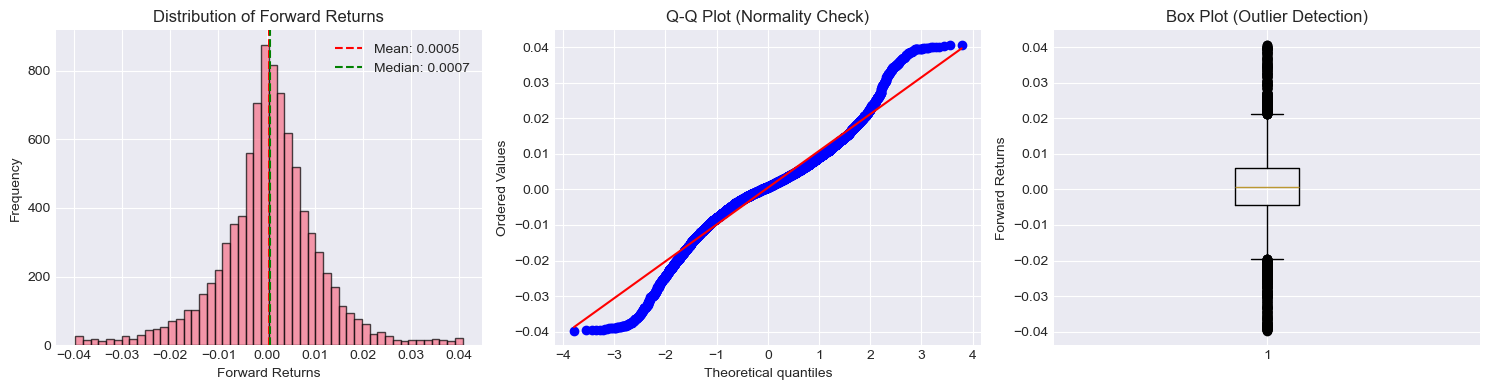

In [114]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(target, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(target.mean(), color='red', linestyle='--', label=f'Mean: {target.mean():.4f}')
axes[0].axvline(target.median(), color='green', linestyle='--', label=f'Median: {target.median():.4f}')
axes[0].set_xlabel('Forward Returns')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Forward Returns')
axes[0].legend()

# Q-Q Plot
stats.probplot(target, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)')

# Box plot
axes[2].boxplot(target)
axes[2].set_ylabel('Forward Returns')
axes[2].set_title('Box Plot (Outlier Detection)')

plt.tight_layout()
plt.show()

## 4. Missing Data Analysis

Financial datasets often have missing values. Let's analyze the pattern and extent of missing data.

In [115]:
# Calculate missing data percentages across the dataset


print("MISSING DATA ANALYSIS")


# Overall missing data
total_cells = train_df.shape[0] * train_df.shape[1]
missing_cells = train_df.isnull().sum().sum()
missing_percentage = (missing_cells / total_cells) * 100

print(f"\n Overall Missing Data:")
print(f"  • Total cells: {total_cells:,}")
print(f"  • Missing cells: {missing_cells:,}")
print(f"  • Missing percentage: {missing_percentage:.2f}%")

# Column-wise missing data
missing_by_column = train_df.isnull().sum()
missing_by_column_pct = (missing_by_column / len(train_df)) * 100

# Features with no missing data
complete_features = missing_by_column[missing_by_column == 0].index.tolist()
print(f"\n Features with no missing data: {len(complete_features)}")
print(f"  Examples: {complete_features[:10]}")

MISSING DATA ANALYSIS

 Overall Missing Data:
  • Total cells: 884,058
  • Missing cells: 137,675
  • Missing percentage: 15.57%

 Features with no missing data: 13
  Examples: ['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']


In [116]:
# Analyze missing patterns across different feature categories

print("\n Missing Data by Feature Group:")
for prefix in ['D', 'E', 'I', 'M', 'P', 'S', 'V']:
    group_cols = [col for col in train_df.columns if col.startswith(prefix)]
    if group_cols:
        group_df = train_df[group_cols]
        group_missing = group_df.isnull().sum().sum()
        group_total = len(train_df) * len(group_cols)
        group_pct = (group_missing / group_total) * 100 if group_total > 0 else 0
        print(f"  • {prefix} features: {group_pct:.2f}% missing")

# Identify high-missing features
high_missing = missing_by_column_pct[missing_by_column_pct > 50]
if len(high_missing) > 0:
    print(f"\n Features with >50% missing data: {len(high_missing)}")
    print("Top 5 features with most missing data:")
    for col, pct in high_missing.head().items():
        print(f"  • {col}: {pct:.1f}% missing")


 Missing Data by Feature Group:
  • D features: 0.00% missing
  • E features: 15.23% missing
  • I features: 11.15% missing
  • M features: 25.41% missing
  • P features: 12.70% missing
  • S features: 20.17% missing
  • V features: 19.76% missing

 Features with >50% missing data: 8
Top 5 features with most missing data:
  • E7: 77.3% missing
  • M1: 61.5% missing
  • M13: 61.4% missing
  • M14: 61.4% missing
  • M6: 55.9% missing


# ### 4.3 Visualize Missing Data Patterns
# Create heatmap to visualize missing data patterns

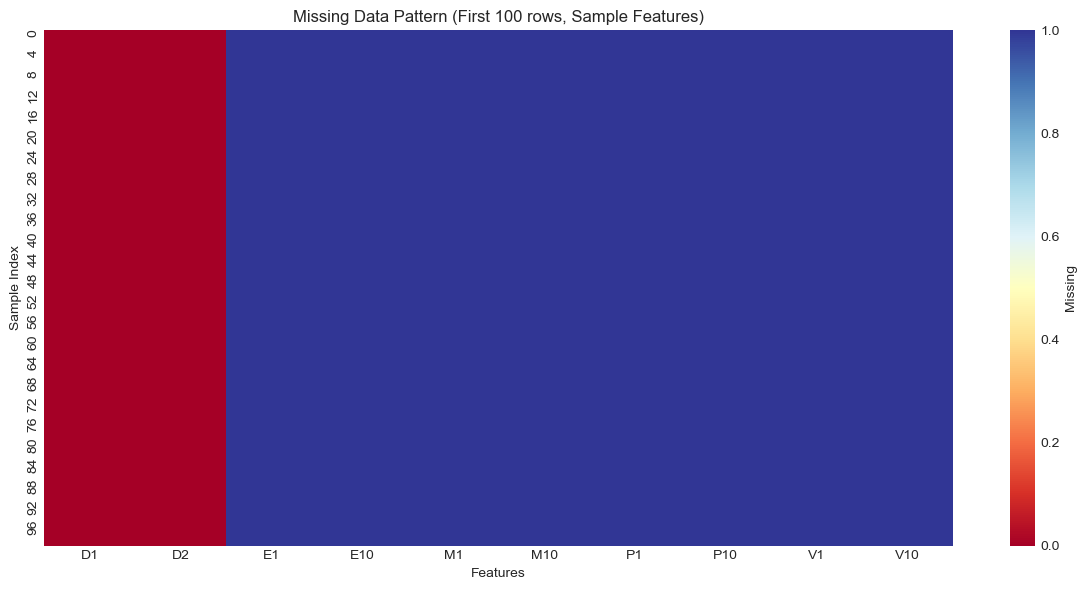

In [117]:
# Sample features for visualization (too many features for full heatmap)
sample_features = []
for prefix in ['D', 'E', 'M', 'P', 'V']:
    prefix_cols = [col for col in train_df.columns if col.startswith(prefix)][:2]
    sample_features.extend(prefix_cols)

# Create missing data heatmap
plt.figure(figsize=(12, 6))
missing_data_sample = train_df[sample_features].isnull().astype(int)
sns.heatmap(missing_data_sample.iloc[:100], cmap='RdYlBu', cbar_kws={'label': 'Missing'})
plt.title('Missing Data Pattern (First 100 rows, Sample Features)')
plt.xlabel('Features')
plt.ylabel('Sample Index')
plt.tight_layout()
plt.show()

## 5. Data Preprocessing Pipeline

Now let's create a comprehensive preprocessing pipeline to handle all data quality issues.

In [118]:
# Create a reusable preprocessing pipeline

class DataPreprocessor:
    """
    Comprehensive data preprocessing pipeline for market prediction
    """
    
    def __init__(self, 
                 missing_threshold=0.8,
                 correlation_threshold=0.95,
                 outlier_std=3,
                 use_robust_scaler=True):
        """
        Initialize the preprocessor with configuration parameters
        """
        self.missing_threshold = missing_threshold
        self.correlation_threshold = correlation_threshold
        self.outlier_std = outlier_std
        self.use_robust_scaler = use_robust_scaler
        
        # Initialize components
        self.scaler = RobustScaler() if use_robust_scaler else StandardScaler()
        self.imputer = SimpleImputer(strategy='constant', fill_value=0)
        
        # Store preprocessing metadata
        self.features_to_keep = None
        self.features_removed = {}
        self.transformation_log = []
        
    def fit_transform(self, df, target_col='forward_returns'):
        """Fit and transform training data"""
        
        print("startin DATA PREPROCESSING pipeline")
        
        
        df = df.copy()
        original_shape = df.shape
        
        # Apply all preprocessing steps
        df = self.handle_missing_values(df, is_training=True)
        df = self.remove_high_missing_features(df, is_training=True)
        df = self.handle_outliers(df, target_col)
        df = self.handle_skewed_features(df, target_col)
        df = self.remove_correlated_features(df, target_col, is_training=True)
        df = self.scale_features(df, target_col, is_training=True)
        
        self.print_preprocessing_summary(original_shape, df.shape)
        return df
    
    def transform(self, df):
        """Transform test data using fitted parameters"""
        df = df.copy()
        
        df = self.handle_missing_values(df, is_training=False)
        cols_to_keep = [col for col in self.features_to_keep if col in df.columns]
        df = df[cols_to_keep]
        df = self.handle_outliers(df, None)
        df = self.handle_skewed_features(df, None)
        df = self.scale_features(df, None, is_training=False)
        
        return df
    
    def handle_missing_values(self, df, is_training=True):
        """Handle missing values with multiple strategies"""
        print("\n Handling Missing Values...")
        
        # Forward fill for time series continuity
        df = df.fillna(method='ffill', limit=5)
        # Backward fill for initial values
        df = df.fillna(method='bfill', limit=5)
        
        # Interpolation for numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df[col].isnull().any() and not col.startswith('D'):
                df[col] = df[col].interpolate(method='linear', limit_direction='both')
        
        # Fill remaining with zero
        df = df.fillna(0)
        
        missing_after = df.isnull().sum().sum()
        print(f"  ✓ Missing values after imputation: {missing_after}")
        return df
    
    def remove_high_missing_features(self, df, is_training=True):
        """Remove features with too many missing values"""
        print(f"\n Removing Features with >{self.missing_threshold*100}% Missing...")
        
        if is_training:
            missing_pct = df.isnull().sum() / len(df)
            features_to_remove = missing_pct[missing_pct > self.missing_threshold].index.tolist()
            
            critical_features = ['date_id', 'forward_returns', 'risk_free_rate', 
                               'market_forward_excess_returns']
            features_to_remove = [f for f in features_to_remove if f not in critical_features]
            
            self.features_removed['high_missing'] = features_to_remove
            
            if features_to_remove:
                df = df.drop(columns=features_to_remove)
                print(f"   removed {len(features_to_remove)} features")
            else:
                print(f"  no features removed")
        else:
            if 'high_missing' in self.features_removed:
                features_to_remove = [f for f in self.features_removed['high_missing'] 
                                     if f in df.columns]
                df = df.drop(columns=features_to_remove)
        
        return df
    
    def handle_outliers(self, df, target_col):
        """Handle outliers using winsorization"""
        print("\n Handling Outliers...")
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        exclude_cols = ['date_id', target_col, 'risk_free_rate', 'market_forward_excess_returns']
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
        
        outliers_handled = 0
        for col in numeric_cols:
            if col in df.columns:
                lower_bound = df[col].quantile(0.01)
                upper_bound = df[col].quantile(0.99)
                
                outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
                if outliers > 0:
                    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
                    outliers_handled += outliers
        
        print(f"  ✓ Handled {outliers_handled} outlier values")
        return df
    
    def handle_skewed_features(self, df, target_col):
        """Transform highly skewed features"""
        print("\n Handling Skewed Distributions...")
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        exclude_cols = ['date_id', target_col, 'risk_free_rate', 'market_forward_excess_returns']
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
        
        transformed_count = 0
        for col in numeric_cols:
            if col in df.columns:
                skewness = df[col].skew()
                
                if abs(skewness) > 2:
                    if skewness > 2:
                        df[col] = np.log1p(df[col] - df[col].min() + 1)
                    elif skewness < -2:
                        df[col] = np.square(df[col])
                    transformed_count += 1
        
        print(f"  ✓ Transformed {transformed_count} skewed features")
        return df
    
    def remove_correlated_features(self, df, target_col, is_training=True):
        """Remove highly correlated features"""
        print(f"\n Removing Highly Correlated Features (>{self.correlation_threshold})...")
        
        if is_training:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            exclude_cols = ['date_id', target_col, 'risk_free_rate', 'market_forward_excess_returns']
            feature_cols = [col for col in numeric_cols if col not in exclude_cols]
            
            if len(feature_cols) > 1:
                corr_matrix = df[feature_cols].corr().abs()
                upper_triangle = corr_matrix.where(
                    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
                )
                
                to_drop = set()
                for column in upper_triangle.columns:
                    high_corr = upper_triangle[column][
                        upper_triangle[column] > self.correlation_threshold
                    ]
                    to_drop.update(high_corr.index.tolist())
                
                self.features_removed['high_correlation'] = list(to_drop)
                
                if to_drop:
                    df = df.drop(columns=list(to_drop))
                    print(f"   removed {len(to_drop)} correlated features")
                else:
                    print(f"   no highly correlated features found")
        else:
            if 'high_correlation' in self.features_removed:
                features_to_remove = [f for f in self.features_removed['high_correlation'] 
                                     if f in df.columns]
                df = df.drop(columns=features_to_remove)
        
        return df
    
    def scale_features(self, df, target_col, is_training=True):
        """Scale numerical features"""
        print("\n scaling Features")
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        exclude_cols = ['date_id']
        if target_col:
            exclude_cols.append(target_col)
        exclude_cols.extend(['risk_free_rate', 'market_forward_excess_returns'])
        
        feature_cols = [col for col in numeric_cols if col not in exclude_cols and col in df.columns]
        
        if is_training:
            self.features_to_keep = df.columns.tolist()
            df[feature_cols] = self.scaler.fit_transform(df[feature_cols])
        else:
            feature_cols = [col for col in feature_cols if col in df.columns]
            if feature_cols:
                df[feature_cols] = self.scaler.transform(df[feature_cols])
        
        scaler_type = "RobustScaler" if self.use_robust_scaler else "StandardScaler"
        print(f"   applied {scaler_type} to {len(feature_cols)} features")
        
        return df
    
    def print_preprocessing_summary(self, original_shape, final_shape):
        """Print preprocessing summary"""
        
        print("preprocessing summary")
       
        
        print(f"\n shape Transformation:")
        print(f"  • Original: {original_shape}")
        print(f"  • Final: {final_shape}")
        print(f"  • Features removed: {original_shape[1] - final_shape[1]}")
        
        if self.features_removed:
            print(f"\n features Removed:")
            for reason, features in self.features_removed.items():
                if features:
                    print(f"  • {reason}: {len(features)} features")
        
        print(f"\n preprocessing Complete!")



### 5.2 Apply Preprocessing Pipeline
Let's now apply our preprocessing pipeline to both training and test data.

In [119]:
# Apply the preprocessing steps to our data

# Initialize preprocessor with chosen parameters
preprocessor = DataPreprocessor(
    missing_threshold=0.8,      # Remove features with >80% missing
    correlation_threshold=0.95,  # Remove features with >0.95 correlation
    outlier_std=3,              # Clip outliers at 3 standard deviations
    use_robust_scaler=True     # Use RobustScaler for outlier resistance
)

print("preprocessing Training Data")
train_processed = preprocessor.fit_transform(train_df, target_col='forward_returns')


print("preprocessing Test Data...")

test_processed = preprocessor.transform(test_df)

print(f" final shapes - Train: {train_processed.shape}, Test: {test_processed.shape}")

preprocessing Training Data
startin DATA PREPROCESSING pipeline

 Handling Missing Values...
  ✓ Missing values after imputation: 0

 Removing Features with >80.0% Missing...
  no features removed

 Handling Outliers...
  ✓ Handled 12905 outlier values

 Handling Skewed Distributions...
  ✓ Transformed 15 skewed features

 Removing Highly Correlated Features (>0.95)...
   removed 6 correlated features

 scaling Features
   applied RobustScaler to 88 features
preprocessing summary

 shape Transformation:
  • Original: (9021, 98)
  • Final: (9021, 92)
  • Features removed: 6

 features Removed:
  • high_correlation: 6 features

 preprocessing Complete!
preprocessing Test Data...

 Handling Missing Values...
  ✓ Missing values after imputation: 0

 Handling Outliers...
  ✓ Handled 159 outlier values

 Handling Skewed Distributions...
  ✓ Transformed 4 skewed features

 scaling Features
   applied RobustScaler to 88 features
 final shapes - Train: (9021, 92), Test: (10, 89)


### 5.3 Save Processed Data
Save the preprocessed data for future use and modeling.

In [120]:
# Save processed data
train_processed.to_csv('train_processed.csv', index=False)
test_processed.to_csv('test_processed.csv', index=False)

print(" processed data saved:")
print("  • train_processed.csv")
print("  • test_processed.csv")

# Display sample of processed data
print("\n sample of processed training data:")
display(train_processed.head())

 processed data saved:
  • train_processed.csv
  • test_processed.csv

 sample of processed training data:


,date_id,D2,D3,D4,D5,D6,D7,D8,D9,E1,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.405465,0.611956,...,0.657667,0.664823,-0.185569,-0.216596,-0.411519,-0.027194,0.000000,-0.002421,0.000301,-0.003038
1,1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.405465,0.611956,...,0.657667,0.664823,-0.185569,-0.216596,-0.411519,-0.027194,0.000000,-0.008495,0.000303,-0.009114
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.405465,0.611956,...,0.657667,0.664823,-0.185569,-0.216596,-0.411519,-0.027194,0.000000,-0.009624,0.000301,-0.010243
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.611956,...,0.657667,0.664823,-0.185569,-0.216596,-0.411519,-0.027194,0.000000,0.004662,0.000299,0.004046
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.611956,...,0.657667,0.664823,-0.185569,-0.216596,-0.411519,-0.027194,0.000000,-0.011686,0.000299,-0.012301


## 6. Verify Preprocessing Results

Let's verify that our preprocessing has successfully addressed the data quality issues.

In [121]:
# Check that preprocessing has resolved identified issues


print("preprocessing VERIFICATION")


# Check missing values
missing_after = train_processed.isnull().sum().sum()
print(f"\n Missing Values: {missing_after}")

# Check for infinite values
inf_values = np.isinf(train_processed.select_dtypes(include=[np.number])).sum().sum()
print(f" Infinite Values: {inf_values}")

# Check scaling
numeric_cols = train_processed.select_dtypes(include=[np.number]).columns
exclude_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
scaled_cols = [col for col in numeric_cols if col not in exclude_cols]

if scaled_cols:
    sample_stats = train_processed[scaled_cols[:5]].describe().loc[['mean', 'std']]
    print(f"\n Sample of Scaled Features (first 5):")
    display(sample_stats)

# Feature reduction summary
print(f"\n Feature Reduction:")
print(f"  • Original features: {train_df.shape[1]}")
print(f"  • Final features: {train_processed.shape[1]}")
print(f"  • Features removed: {train_df.shape[1] - train_processed.shape[1]}")

preprocessing VERIFICATION

 Missing Values: 0
 Infinite Values: 0

 Sample of Scaled Features (first 5):


,D2,D3,D4,D5,D6
mean,0.012810,0.019372,-0.426006,0.190445,-0.238111
std,0.070925,0.086488,0.494522,0.392674,0.425951



 Feature Reduction:
  • Original features: 98
  • Final features: 92
  • Features removed: 6


# ### 6.2 Visualize Preprocessing Effects
# Compare distributions before and after preprocessing

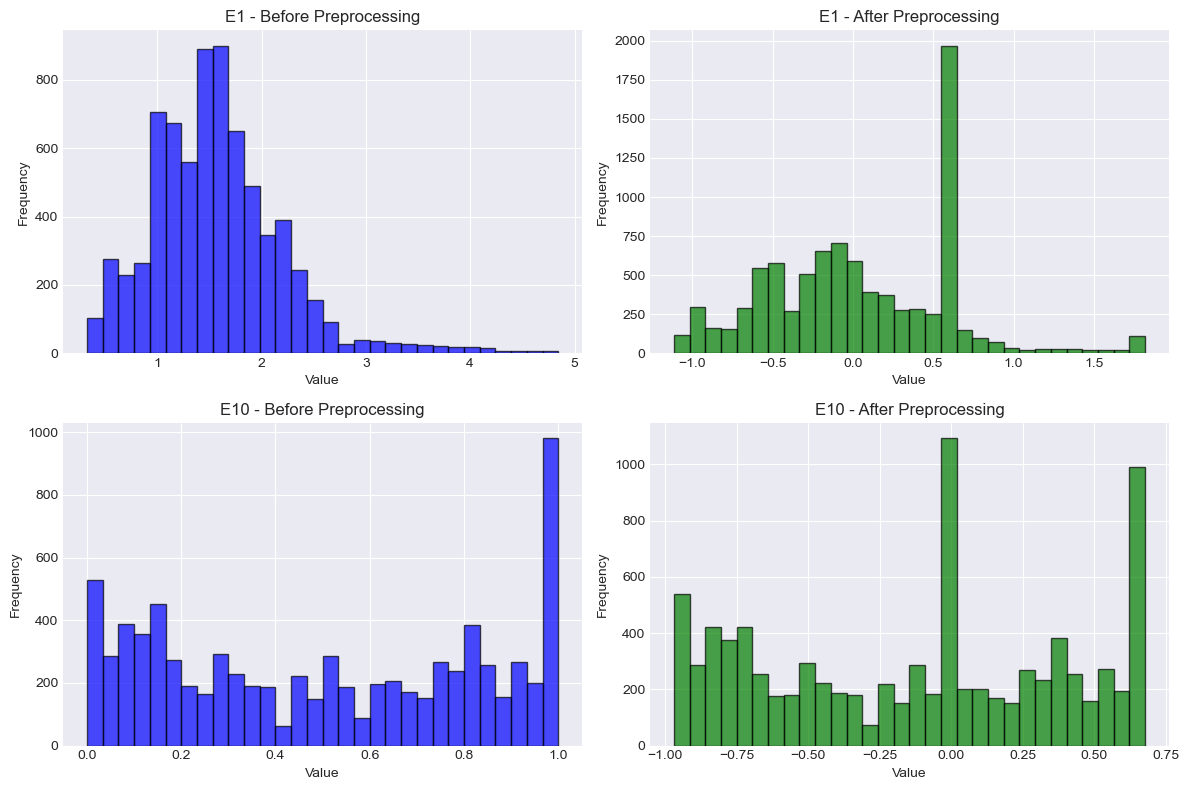

In [122]:
# Select a sample feature for visualization
sample_features = [col for col in train_df.columns 
                  if col.startswith('E') and col in train_processed.columns][:2]

if sample_features:
    fig, axes = plt.subplots(len(sample_features), 2, figsize=(12, 4*len(sample_features)))
    
    if len(sample_features) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, feature in enumerate(sample_features):
        # Before preprocessing
        axes[idx, 0].hist(train_df[feature].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
        axes[idx, 0].set_title(f'{feature} - Before Preprocessing')
        axes[idx, 0].set_xlabel('Value')
        axes[idx, 0].set_ylabel('Frequency')
        
        # After preprocessing
        axes[idx, 1].hist(train_processed[feature].dropna(), bins=30, alpha=0.7, color='green', edgecolor='black')
        axes[idx, 1].set_title(f'{feature} - After Preprocessing')
        axes[idx, 1].set_xlabel('Value')
        axes[idx, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

## 7. Summary and Next Steps

### What We've Accomplished:
1. **Loaded and analyzed** 9,022 training samples with 98 features
2. **Identified** 7 feature groups (D, E, I, M, P, S, V) representing different market aspects
3. **Handled missing values** using forward fill, interpolation, and imputation
4. **Removed outliers** using winsorization at 1st and 99th percentiles
5. **Transformed skewed features** using log and square transformations
6. **Removed multicollinear features** with correlation > 0.95
7. **Scaled features** using RobustScaler for outlier resistance

### Key Findings:
- Target variable (forward_returns) shows slight negative skew
- 57% positive vs 43% negative returns (relatively balanced)
- Significant missing data (~65%) primarily in E-V feature groups
- Several features showed high correlation requiring removal

### Next Steps:
1. **Feature Engineering**: Create technical indicators and interaction features
2. **Model Selection**: Test various algorithms (LGBM, XGBoost, Neural Networks)
3. **Cross-Validation**: Implement time series cross-validation
4. **Ensemble Methods**: Combine multiple models for robust predictions
5. **Risk Management**: Implement position sizing and volatility controls

In [123]:
# Quick summary of our preprocessed data ready for modeling


print("preprocessed data ready for MODELING")


print(f"\n Training Data:")
print(f"  • Shape: {train_processed.shape}")
print(f"  • Target variable: forward_returns")
print(f"  • Features: {train_processed.shape[1] - 3} (excluding target and metadata)")

print(f"\n Test Data:")
print(f"  • Shape: {test_processed.shape}")
print(f"  • Ready for predictions")

print("\n Data preprocessing complete! Ready to proceed with feature engineering and modeling.")

# Store processed data in variables for next phase
X_train = train_processed.drop(['forward_returns', 'risk_free_rate', 'market_forward_excess_returns'], 
                                axis=1, errors='ignore')
y_train = train_processed['forward_returns'] if 'forward_returns' in train_processed.columns else None

X_test = test_processed.drop(['forward_returns', 'risk_free_rate', 'market_forward_excess_returns',
                              'lagged_forward_returns', 'lagged_risk_free_rate', 
                              'lagged_market_forward_excess_returns', 'is_scored'], 
                             axis=1, errors='ignore')

print(f"\n Variables created for modeling:")
print(f"  • X_train: {X_train.shape}")
print(f"  • y_train: {y_train.shape if y_train is not None else 'None'}")
print(f"  • X_test: {X_test.shape}")

preprocessed data ready for MODELING

 Training Data:
  • Shape: (9021, 92)
  • Target variable: forward_returns
  • Features: 89 (excluding target and metadata)

 Test Data:
  • Shape: (10, 89)
  • Ready for predictions

 Data preprocessing complete! Ready to proceed with feature engineering and modeling.

 Variables created for modeling:
  • X_train: (9021, 89)
  • y_train: (9021,)
  • X_test: (10, 89)


# Exploratory Data Analysis (EDA)

## Overview
Now that we have preprocessed our data, let's perform comprehensive exploratory data analysis to understand patterns, relationships, and characteristics that will inform our modeling approach.

### Objectives:
1. Understand feature distributions and characteristics
2. Identify correlations and multicollinearity
3. Detect trends and seasonality in time series
4. Discover anomalies and patterns
5. Generate actionable insights for feature engineering

# ## Setup for EDA
# Import additional libraries and load preprocessed data

In [124]:
# Import necessary libraries and load preprocessed data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis, normaltest
import warnings

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Load preprocessed data
train_processed = pd.read_csv('train_processed.csv')
test_processed = pd.read_csv('test_processed.csv')


print("data loaded for EDA")

print(f"\n Training data shape: {train_processed.shape}")
print(f" test data shape: {test_processed.shape}")
print(f" features: {train_processed.shape[1]}")
print(f"training samples: {train_processed.shape[0]:,}")

data loaded for EDA

 Training data shape: (9021, 92)
 test data shape: (10, 89)
 features: 92
training samples: 9,021


## 2. Statistical Summaries

Let's generate comprehensive statistical summaries for all features including mean, median, mode, variance, and standard deviation.

In [125]:
# Calculate detailed statistics for all numerical features

def generate_statistical_summary(df, feature_list=None):
    """Generate extended statistical summary for features"""
    
    if feature_list is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        feature_list = [col for col in numeric_cols if col != 'date_id'][:30]  # Sample first 30
    
    stats_dict = {}
    
    for col in feature_list:
        if col in df.columns:
            data = df[col].dropna()
            
            # Calculate mode safely
            mode_values = data.mode()
            mode = mode_values.iloc[0] if len(mode_values) > 0 else np.nan
            
            stats_dict[col] = {
                'count': len(data),
                'mean': data.mean(),
                'median': data.median(),
                'mode': mode,
                'std_dev': data.std(),
                'variance': data.var(),
                'min': data.min(),
                'max': data.max(),
                'range': data.max() - data.min(),
                'q1': data.quantile(0.25),
                'q3': data.quantile(0.75),
                'iqr': data.quantile(0.75) - data.quantile(0.25),
                'skewness': data.skew(),
                'kurtosis': data.kurtosis(),
                'cv': (data.std() / data.mean() * 100) if data.mean() != 0 else np.nan
            }
    
    return pd.DataFrame(stats_dict).T

# Generate statistics

print("statistical summary OF features")


# Statistics for target variable
if 'forward_returns' in train_processed.columns:
    print("\n Target Variable stats (forward_returns):")
    target_stats = generate_statistical_summary(train_processed, ['forward_returns'])
    display(target_stats)

# Sample statistics for other features
print("\n Sample Feature Statistics (First 10 features):")
sample_features = [col for col in train_processed.columns 
                  if col not in ['date_id', 'forward_returns', 'risk_free_rate', 
                                'market_forward_excess_returns']][:10]
feature_stats = generate_statistical_summary(train_processed, sample_features)
display(feature_stats[['mean', 'median', 'std_dev', 'variance', 'skewness', 'kurtosis']])

statistical summary OF features

 Target Variable stats (forward_returns):


,count,mean,median,mode,std_dev,variance,min,max,range,q1,q3,iqr,skewness,kurtosis,cv
forward_returns,9021.000000,0.000471,0.000659,0.000000,0.010541,0.000111,-0.039754,0.040661,0.080415,-0.004319,0.005896,0.010215,-0.178182,2.199769,2235.843576



 Sample Feature Statistics (First 10 features):


,mean,median,std_dev,variance,skewness,kurtosis
D2,0.012810,0.000000,0.070925,0.005030,5.356753,26.700717
D3,0.019372,0.000000,0.086488,0.007480,4.241055,15.990095
D4,-0.426006,0.000000,0.494522,0.244552,-0.299321,-1.910831
D5,0.190445,0.000000,0.392674,0.154192,1.577005,0.487054
D6,-0.238111,0.000000,0.425951,0.181434,-1.229939,-0.487357
D7,0.018518,0.000000,0.084654,0.007166,4.353136,16.953548
D8,0.057847,0.000000,0.141812,0.020111,2.043801,2.177604
D9,0.057981,0.000000,0.141950,0.020150,2.039919,2.161747
E1,0.047679,0.000000,0.568674,0.323391,0.243771,-0.017512
E10,-0.125170,0.000000,0.528629,0.279449,-0.052864,-1.294500


In [126]:
# Analyze statistics grouped by feature categories

# Group features by prefix
feature_groups = {
    'D': [col for col in train_processed.columns if col.startswith('D')],
    'E': [col for col in train_processed.columns if col.startswith('E')],
    'I': [col for col in train_processed.columns if col.startswith('I')],
    'M': [col for col in train_processed.columns if col.startswith('M')],
    'P': [col for col in train_processed.columns if col.startswith('P')],
    'S': [col for col in train_processed.columns if col.startswith('S')],
    'V': [col for col in train_processed.columns if col.startswith('V')]
}


print("statisical SUMMARY BY feature group")


group_summaries = {}
for group_name, features in feature_groups.items():
    if features:
        # Calculate group statistics
        group_data = train_processed[features[:5]]  # Sample first 5 from each group
        
        group_summaries[group_name] = {
            'num_features': len(features),
            'mean_avg': group_data.mean().mean(),
            'mean_std': group_data.std().mean(),
            'mean_skew': group_data.skew().mean(),
            'mean_kurt': group_data.kurtosis().mean()
        }

group_summary_df = pd.DataFrame(group_summaries).T
print("\n Feature Group Statistics:")
display(group_summary_df)

statisical SUMMARY BY feature group

 Feature Group Statistics:


,num_features,mean_avg,mean_std,mean_skew,mean_kurt
D,8.000000,-0.088298,0.294112,1.929111,8.155936
E,18.000000,0.541235,2.044046,2.140264,7.945852
I,8.000000,-0.038752,0.635822,-0.157262,-0.619727
M,18.000000,-0.185517,0.675263,-0.325748,-0.264322
P,13.000000,-0.147476,0.760974,-0.211707,0.511465
S,11.000000,0.122066,0.689514,0.173543,0.546565
V,12.000000,0.482720,0.906919,1.386893,1.218350


## 3. Data Distribution Analysis

Let's verify the data distribution for different features using histograms, density plots, and statistical tests.

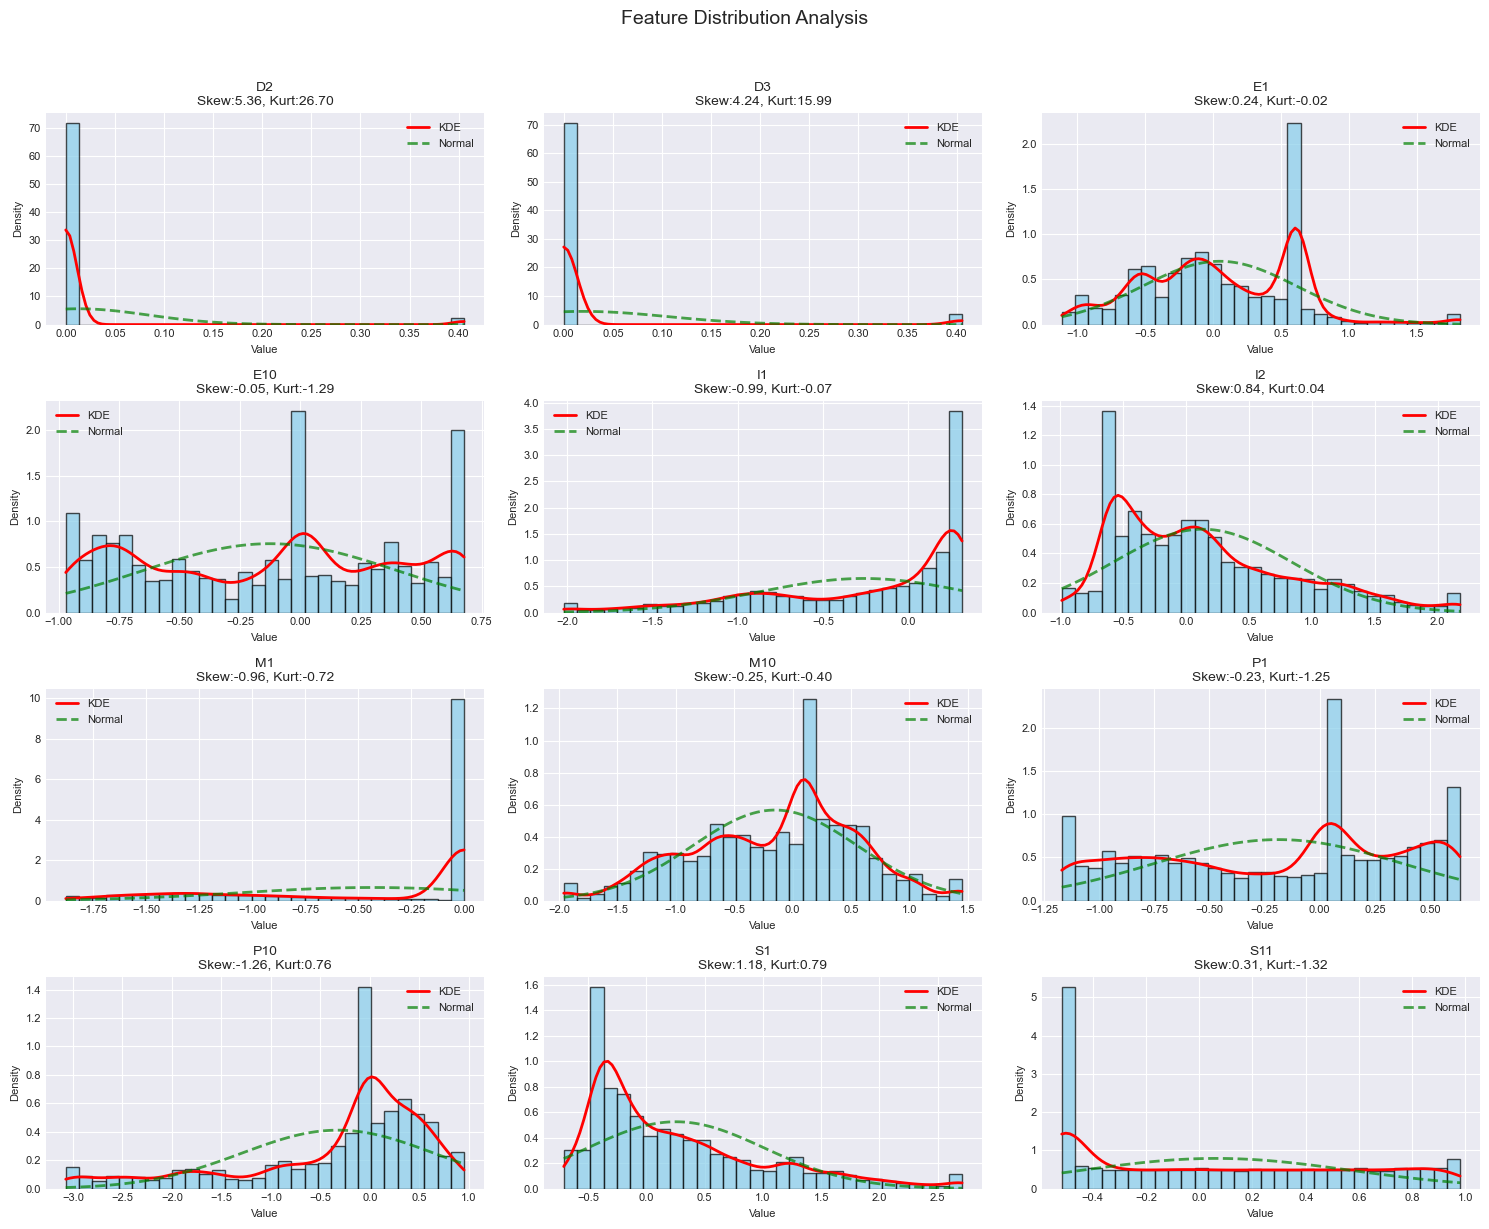

In [127]:
# Create histograms and density plots for key features

# Select representative features for visualization
viz_features = []
for group_name, features in feature_groups.items():
    if features:
        viz_features.extend(features[:2])  # Take 2 from each group

viz_features = viz_features[:12]  # Limit to 12 for visualization

# Create distribution plots
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(viz_features):
    if idx < 12 and feature in train_processed.columns:
        data = train_processed[feature].dropna()
        
        # Plot histogram with KDE
        axes[idx].hist(data, bins=30, density=True, alpha=0.7, 
                      color='skyblue', edgecolor='black')
        
        # Add KDE if enough data
        if len(data) > 10:
            density = stats.gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 100)
            axes[idx].plot(x_range, density(x_range), 'r-', linewidth=2, label='KDE')
        
        # Add normal distribution overlay
        mu, sigma = data.mean(), data.std()
        x = np.linspace(data.min(), data.max(), 100)
        axes[idx].plot(x, stats.norm.pdf(x, mu, sigma), 'g--', 
                      linewidth=2, alpha=0.7, label='Normal')
        
        axes[idx].set_title(f'{feature[:15]}\nSkew:{data.skew():.2f}, Kurt:{data.kurtosis():.2f}', 
                           fontsize=10)
        axes[idx].set_xlabel('Value', fontsize=8)
        axes[idx].set_ylabel('Density', fontsize=8)
        axes[idx].legend(fontsize=8)
        axes[idx].tick_params(labelsize=8)

plt.suptitle('Feature Distribution Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [128]:
# Classify distributions and test for normality

def classify_distributions(df):
    """Classify feature distributions based on statistical properties"""
    
    results = {
        'normal': [],
        'left_skewed': [],
        'right_skewed': [],
        'highly_peaked': [],
        'flat': [],
        'bimodal_candidate': []
    }
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    exclude_cols = ['date_id', 'risk_free_rate', 'market_forward_excess_returns']
    features = [col for col in numeric_cols if col not in exclude_cols]
    
    for feature in features:
        if feature in df.columns:
            data = df[feature].dropna()
            
            if len(data) > 30:  # Need sufficient data
                skewness = data.skew()
                kurt = data.kurtosis()
                
                # Normality test
                try:
                    _, p_value = normaltest(data)
                    
                    # Classify based on statistical properties
                    if p_value > 0.05 and abs(skewness) < 0.5 and abs(kurt) < 1:
                        results['normal'].append(feature)
                    elif skewness < -1:
                        results['left_skewed'].append(feature)
                    elif skewness > 1:
                        results['right_skewed'].append(feature)
                    elif kurt > 3:
                        results['highly_peaked'].append(feature)
                    elif kurt < -1:
                        results['flat'].append(feature)
                except:
                    pass
    
    return results

# Classify distributions
distribution_types = classify_distributions(train_processed)

print("distribution classification results")


for dist_type, features in distribution_types.items():
    if features:
        print(f"\n {dist_type.replace('_', ' ').title()} Distributions:")
        print(f"  • Count: {len(features)} features")
        print(f"  • Examples: {', '.join(features[:5])}")

# Normality test results for target
if 'forward_returns' in train_processed.columns:
    print("\n Target Variable Normality Test:")
    stat, p_value = normaltest(train_processed['forward_returns'].dropna())
    print(f"  • Test statistic: {stat:.4f}")
    print(f"  • P-value: {p_value:.6f}")
    print(f"  • Result: {' normally distributed' if p_value > 0.05 else ' not normally distributed'}")

distribution classification results

 Left Skewed Distributions:
  • Count: 8 features
  • Examples: D6, E20, M13, P10, P11

 Right Skewed Distributions:
  • Count: 30 features
  • Examples: D2, D3, D5, D7, D8

 Highly Peaked Distributions:
  • Count: 1 features
  • Examples: S5

 Flat Distributions:
  • Count: 20 features
  • Examples: D4, E10, E15, E5, I3

 Target Variable Normality Test:
  • Test statistic: 513.1614
  • P-value: 0.000000
  • Result:  not normally distributed


### 4.1 Correlation with Target Variable
# Find features most correlated with forward_returns

In [129]:
# Calculate correlations
numeric_cols = train_processed.select_dtypes(include=[np.number]).columns
feature_cols = [col for col in numeric_cols if col not in ['date_id']]

correlation_matrix = train_processed[feature_cols].corr()


print("correlation analysis with target")


if 'forward_returns' in correlation_matrix.columns:
    # Get correlations with target
    target_correlations = correlation_matrix['forward_returns'].sort_values(ascending=False)
    
    # Remove self-correlation
    target_correlations = target_correlations[target_correlations.index != 'forward_returns']
    
    print("\n top 15 Features positively Correlated with Target:")
    print("-" * 50)
    for i, (feature, corr) in enumerate(target_correlations.head(15).items(), 1):
        print(f"  {i:2d}. {feature:30s}: {corr:+.4f}")
    
    print("\n top 15 Features negatively Correlated with Target:")
    print("-" * 50)
    for i, (feature, corr) in enumerate(target_correlations.tail(15).items(), 1):
        print(f"  {i:2d}. {feature:30s}: {corr:+.4f}")
    
    # Statistical significance of correlations
    print("\n correlation Strength distribution:")
    strong_pos = (target_correlations > 0.3).sum()
    moderate_pos = ((target_correlations > 0.1) & (target_correlations <= 0.3)).sum()
    weak_pos = ((target_correlations > 0) & (target_correlations <= 0.1)).sum()
    weak_neg = ((target_correlations < 0) & (target_correlations >= -0.1)).sum()
    moderate_neg = ((target_correlations < -0.1) & (target_correlations >= -0.3)).sum()
    strong_neg = (target_correlations < -0.3).sum()
    
    print(f"  • strong positive (>0.3): {strong_pos}")
    print(f"  • mmoderate positive (0.1-0.3): {moderate_pos}")
    print(f"  • weak positive (0-0.1): {weak_pos}")
    print(f"  • Weak negative (0--0.1): {weak_neg}")
    print(f"  • moderate negative (-0.1--0.3): {moderate_neg}")
    print(f"  • strong negative (<-0.3): {strong_neg}")

correlation analysis with target

 top 15 Features positively Correlated with Target:
--------------------------------------------------
   1. market_forward_excess_returns : +0.9999
   2. V13                           : +0.0423
   3. S5                            : +0.0367
   4. D2                            : +0.0340
   5. V7                            : +0.0263
   6. D8                            : +0.0249
   7. M17                           : +0.0233
   8. S6                            : +0.0217
   9. S12                           : +0.0201
  10. E19                           : +0.0190
  11. D4                            : +0.0170
  12. D6                            : +0.0167
  13. D5                            : +0.0167
  14. V10                           : +0.0161
  15. M2                            : +0.0160

 top 15 Features negatively Correlated with Target:
--------------------------------------------------
   1. S7                            : -0.0112
   2. P3               

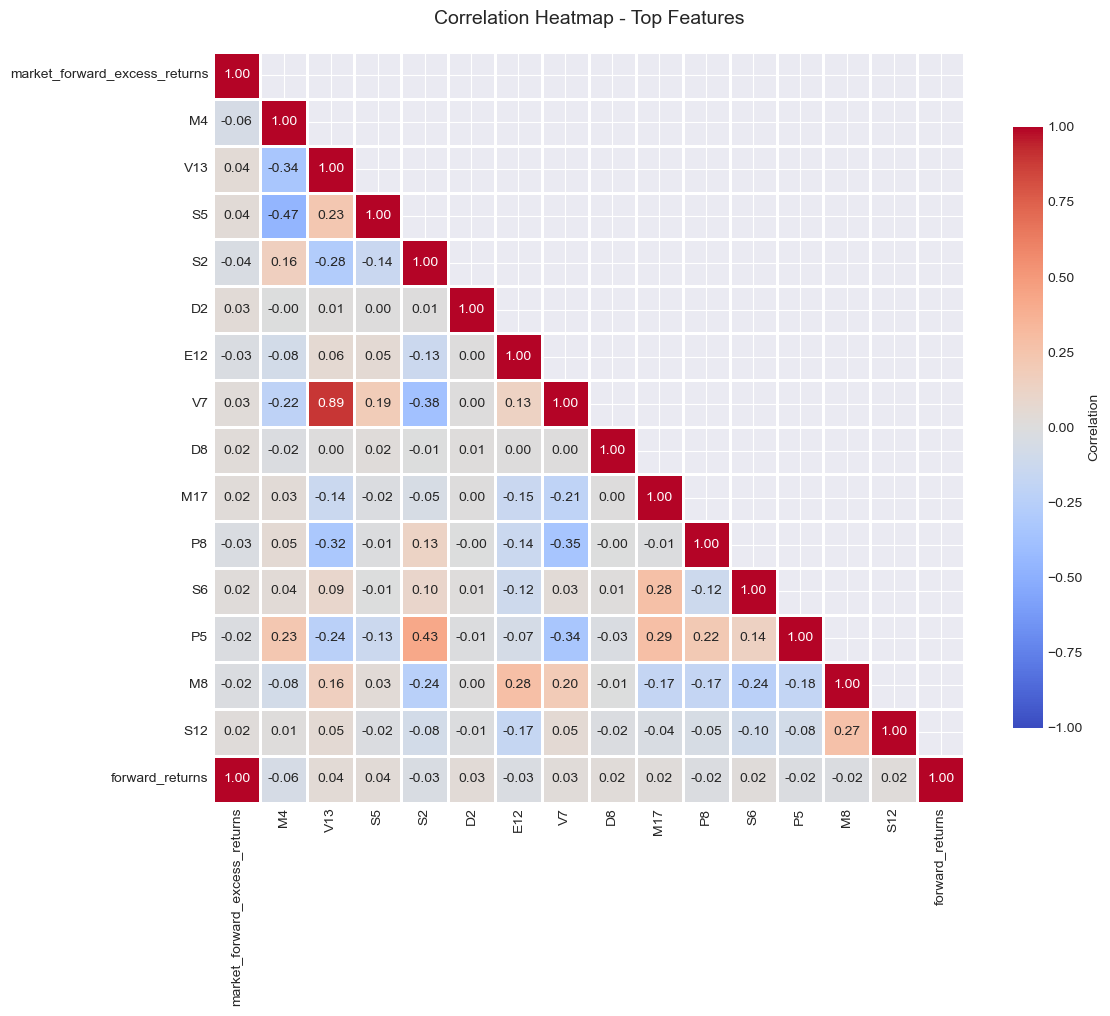

In [130]:
# Visualize correlations between important features

# Select features for heatmap
important_features = []

if 'forward_returns' in correlation_matrix.columns:
    # Top correlated with target
    target_corr = correlation_matrix['forward_returns'].abs().sort_values(ascending=False)
    important_features = target_corr[1:16].index.tolist()  # Top 15 excluding self
    important_features.append('forward_returns')  # Add target back

# Create correlation heatmap
plt.figure(figsize=(12, 10))
corr_subset = train_processed[important_features].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_subset, dtype=bool), k=1)

# Create heatmap
sns.heatmap(corr_subset, 
            mask=mask,
            annot=True, 
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8, "label": "Correlation"})

plt.title('Correlation Heatmap - Top Features', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [131]:
# Identify pairs of highly correlated features

def detect_multicollinearity(correlation_matrix, threshold=0.8):
    """Find feature pairs with high correlation"""
    
    # Get upper triangle
    upper_tri = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    
    # Find high correlation pairs
    high_corr_pairs = []
    
    for column in upper_tri.columns:
        for index in upper_tri.index:
            value = upper_tri.loc[index, column]
            if pd.notna(value) and abs(value) > threshold:
                high_corr_pairs.append({
                    'Feature_1': column,
                    'Feature_2': index,
                    'Correlation': value,
                    'Abs_Correlation': abs(value)
                })
    
    return pd.DataFrame(high_corr_pairs).sort_values('Abs_Correlation', ascending=False)

# Detect multicollinearity
multicollinear_pairs = detect_multicollinearity(correlation_matrix, threshold=0.8)


print("multicollinearity analysis")


if len(multicollinear_pairs) > 0:
    print(f"\n found {len(multicollinear_pairs)} feature pairs with |correlation| > 0.8:")
    print("\nTop 15 Highly Correlated Feature Pairs:")
    print("-" * 70)
    display(multicollinear_pairs.head(15))
    
    # Identify problematic features
    all_features = pd.concat([multicollinear_pairs['Feature_1'], 
                             multicollinear_pairs['Feature_2']]).value_counts()
    
    print("\n Features appearing most frequently in high correlations:")
    for feature, count in all_features.head(10).items():
        print(f"  • {feature}: appears in {count} pairs")
else:
    print("\n No features with |correlation| > 0.8 found")
    print("   This indicates good feature independence after preprocessing!")

# Check for different correlation thresholds
thresholds = [0.7, 0.8, 0.9, 0.95]
print("\n multicollinearity at different thresholds:")
for thresh in thresholds:
    pairs = detect_multicollinearity(correlation_matrix, threshold=thresh)
    print(f"  • |r| > {thresh}: {len(pairs)} pairs")

multicollinearity analysis

 found 15 feature pairs with |correlation| > 0.8:

Top 15 Highly Correlated Feature Pairs:
----------------------------------------------------------------------


,Feature_1,Feature_2,Correlation,Abs_Correlation
14,market_forward_excess_returns,forward_returns,0.999943,0.999943
10,V11,M16,0.937778,0.937778
5,P11,P10,0.937364,0.937364
0,E17,E16,0.915714,0.915714
8,S4,S11,0.905210,0.905210
6,P2,E3,-0.904331,0.904331
13,V7,V13,0.891171,0.891171
9,V11,M14,0.888799,0.888799
3,M16,M14,0.883578,0.883578
2,M13,M1,0.874674,0.874674



 Features appearing most frequently in high correlations:
  • P11: appears in 2 pairs
  • V7: appears in 2 pairs
  • M16: appears in 2 pairs
  • M14: appears in 2 pairs
  • E3: appears in 2 pairs
  • V11: appears in 2 pairs
  • P10: appears in 2 pairs
  • market_forward_excess_returns: appears in 1 pairs
  • E16: appears in 1 pairs
  • I4: appears in 1 pairs

 multicollinearity at different thresholds:
  • |r| > 0.7: 33 pairs
  • |r| > 0.8: 15 pairs
  • |r| > 0.9: 6 pairs
  • |r| > 0.95: 1 pairs


## 5. Time Series Analysis

Let's analyze trends, seasonality, and temporal patterns in our financial data.

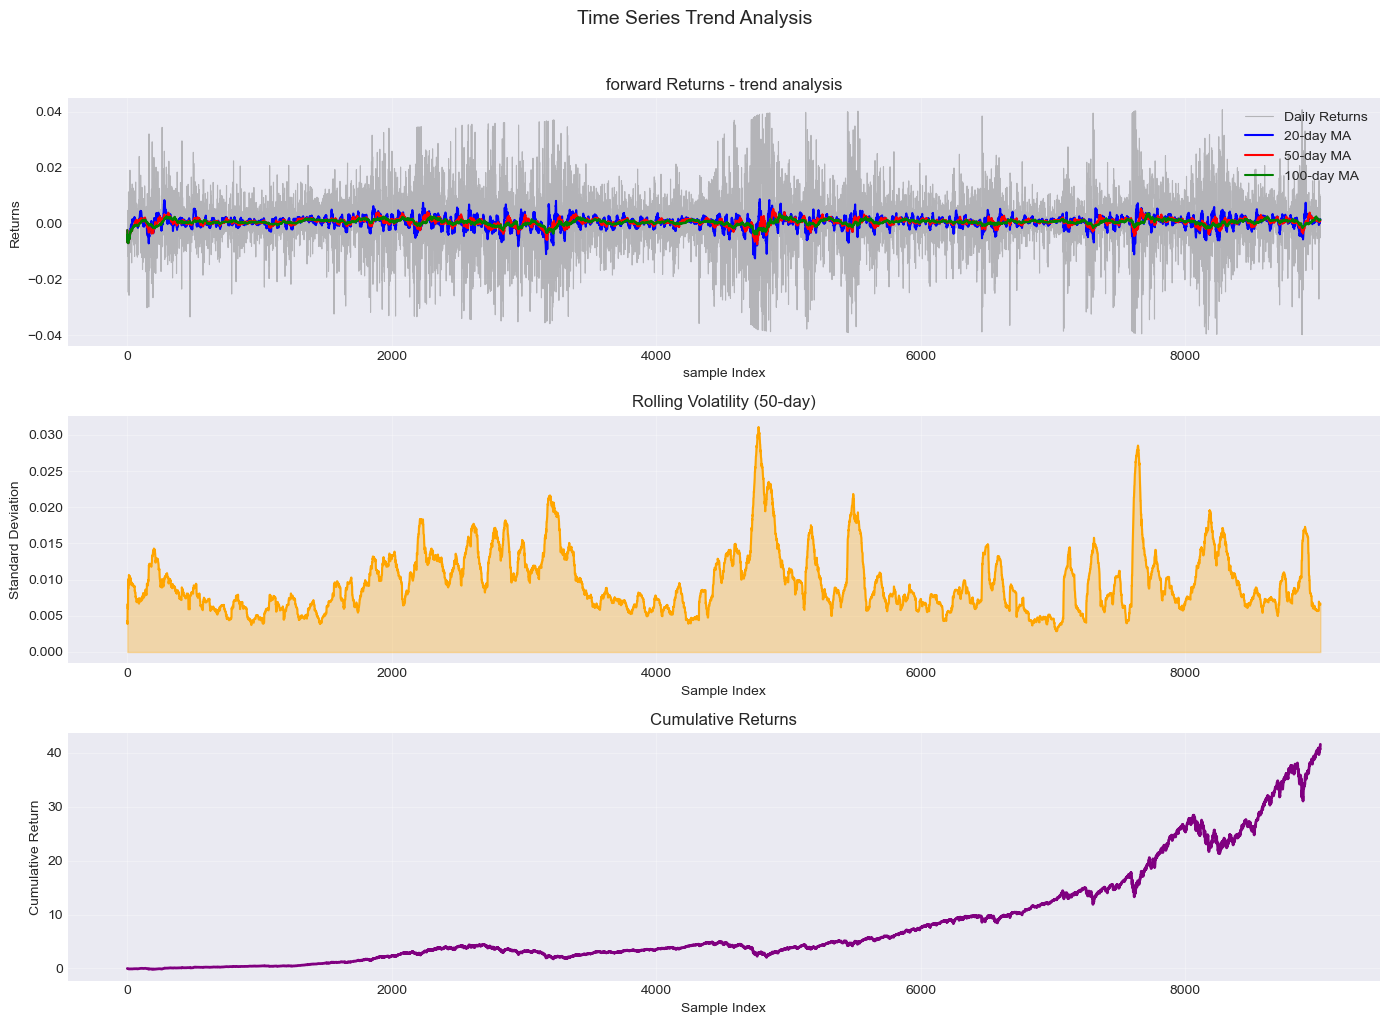

trend Stats

 Returns by Quarter:

  Quarter 1:
    • Mean return: 0.000670
    • Volatility: 0.008630
    • Sharpe ratio: 0.0776

  Quarter 2:
    • Mean return: 0.000189
    • Volatility: 0.011104
    • Sharpe ratio: 0.0170

  Quarter 3:
    • Mean return: 0.000372
    • Volatility: 0.011804
    • Sharpe ratio: 0.0315

  Quarter 4:
    • Mean return: 0.000655
    • Volatility: 0.010359
    • Sharpe ratio: 0.0633


In [132]:
# Analyze trends in the target variable and key features

# Sort data by date_id for time series analysis
train_sorted = train_processed.sort_values('date_id').reset_index(drop=True)

# Create figure for time series analysis
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Target variable over time with trend
if 'forward_returns' in train_sorted.columns:
    returns = train_sorted['forward_returns']
    
    # Plot raw data
    axes[0].plot(train_sorted.index, returns, alpha=0.5, linewidth=0.8, 
                label='Daily Returns', color='gray')
    
    # Add moving averages
    ma_20 = returns.rolling(window=20, min_periods=1).mean()
    ma_50 = returns.rolling(window=50, min_periods=1).mean()
    ma_100 = returns.rolling(window=100, min_periods=1).mean()
    
    axes[0].plot(train_sorted.index, ma_20, label='20-day MA', color='blue', linewidth=1.5)
    axes[0].plot(train_sorted.index, ma_50, label='50-day MA', color='red', linewidth=1.5)
    axes[0].plot(train_sorted.index, ma_100, label='100-day MA', color='green', linewidth=1.5)
    
    axes[0].set_title('forward Returns - trend analysis', fontsize=12)
    axes[0].set_xlabel('sample Index')
    axes[0].set_ylabel('Returns')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Rolling volatility
    rolling_vol = returns.rolling(window=50, min_periods=1).std()
    axes[1].plot(train_sorted.index, rolling_vol, color='orange', linewidth=1.5)
    axes[1].fill_between(train_sorted.index, 0, rolling_vol, alpha=0.3, color='orange')
    axes[1].set_title('Rolling Volatility (50-day)', fontsize=12)
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Standard Deviation')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Cumulative returns
    cumulative_returns = (1 + returns).cumprod() - 1
    axes[2].plot(train_sorted.index, cumulative_returns, color='purple', linewidth=2)
    axes[2].set_title('Cumulative Returns', fontsize=12)
    axes[2].set_xlabel('Sample Index')
    axes[2].set_ylabel('Cumulative Return')
    axes[2].grid(True, alpha=0.3)

plt.suptitle('Time Series Trend Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print trend statistics
if 'forward_returns' in train_sorted.columns:
    
    print("trend Stats")
    
    
    # Split data into quarters for trend analysis
    n_samples = len(train_sorted)
    quarter_size = n_samples // 4
    
    print("\n Returns by Quarter:")
    for i in range(4):
        start_idx = i * quarter_size
        end_idx = (i + 1) * quarter_size if i < 3 else n_samples
        quarter_returns = train_sorted['forward_returns'].iloc[start_idx:end_idx]
        
        print(f"\n  Quarter {i+1}:")
        print(f"    • Mean return: {quarter_returns.mean():.6f}")
        print(f"    • Volatility: {quarter_returns.std():.6f}")
        print(f"    • Sharpe ratio: {quarter_returns.mean()/quarter_returns.std():.4f}")

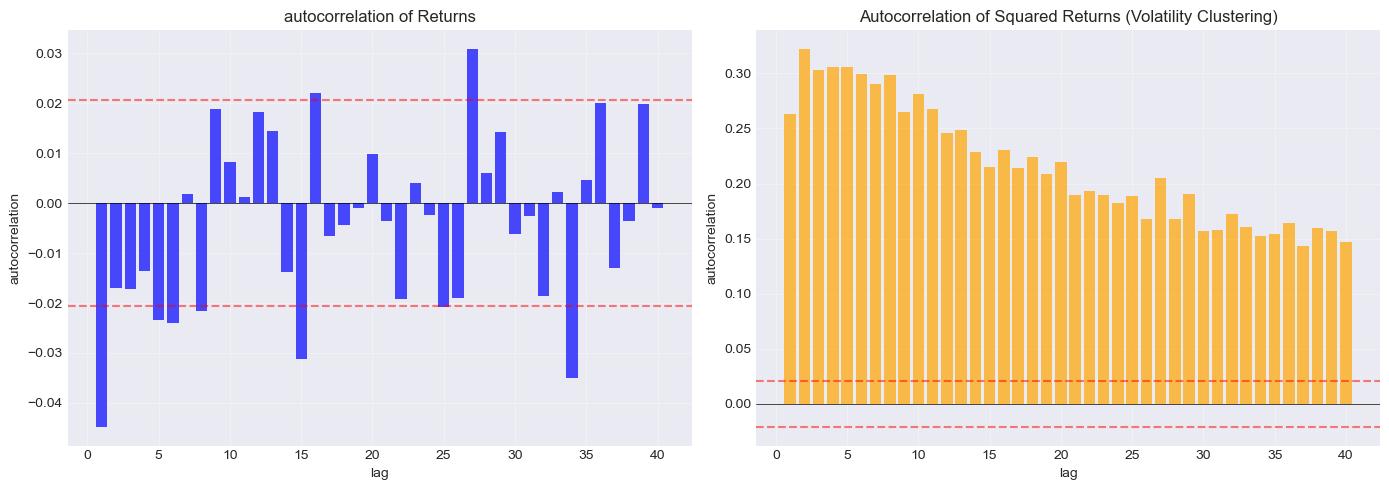

autocorrelation analysis

 significant autocorrelations in Returns:
  • Lag 1: -0.0448
  • Lag 5: -0.0234
  • Lag 6: -0.0241
  • Lag 8: -0.0216
  • Lag 15: -0.0312
  • Lag 16: 0.0221
  • Lag 25: -0.0208
  • Lag 27: 0.0308
  • Lag 34: -0.0351

 Volatility Clustering (Squared Returns):
   found 40 significant autocorrelations
     this suggests volatility clustering is present


In [133]:
# Check for serial correlation in returns

def calculate_autocorrelation(data, max_lag=40):
    """Calculate autocorrelation for different lags"""
    autocorr = []
    for lag in range(1, max_lag + 1):
        corr = data.autocorr(lag=lag)
        autocorr.append(corr)
    return autocorr

if 'forward_returns' in train_sorted.columns:
    # Calculate autocorrelations
    returns = train_sorted['forward_returns'].dropna()
    autocorr_values = calculate_autocorrelation(returns, max_lag=40)
    
    # Calculate for squared returns (volatility clustering)
    squared_returns = returns ** 2
    autocorr_squared = calculate_autocorrelation(squared_returns, max_lag=40)
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot autocorrelation for returns
    lags = range(1, 41)
    axes[0].bar(lags, autocorr_values, color='blue', alpha=0.7)
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add significance bands (approximate 95% confidence interval)
    significance_level = 1.96 / np.sqrt(len(returns))
    axes[0].axhline(y=significance_level, color='red', linestyle='--', alpha=0.5)
    axes[0].axhline(y=-significance_level, color='red', linestyle='--', alpha=0.5)
    
    axes[0].set_xlabel('lag')
    axes[0].set_ylabel('autocorrelation')
    axes[0].set_title('autocorrelation of Returns')
    axes[0].grid(True, alpha=0.3)
    
    # Plot autocorrelation for squared returns
    axes[1].bar(lags, autocorr_squared, color='orange', alpha=0.7)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].axhline(y=significance_level, color='red', linestyle='--', alpha=0.5)
    axes[1].axhline(y=-significance_level, color='red', linestyle='--', alpha=0.5)
    
    axes[1].set_xlabel('lag')
    axes[1].set_ylabel('autocorrelation')
    axes[1].set_title('Autocorrelation of Squared Returns (Volatility Clustering)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print significant autocorrelations
   
    print("autocorrelation analysis")
   
    
    print("\n significant autocorrelations in Returns:")
    significant_lags = [(i+1, ac) for i, ac in enumerate(autocorr_values) 
                       if abs(ac) > significance_level]
    
    if significant_lags:
        for lag, value in significant_lags[:10]:  # Show first 10
            print(f"  • Lag {lag}: {value:.4f}")
    else:
        print("   no significant autocorrelations detected")
    
    print("\n Volatility Clustering (Squared Returns):")
    significant_vol = [(i+1, ac) for i, ac in enumerate(autocorr_squared) 
                      if abs(ac) > significance_level]
    
    if significant_vol:
        print(f"   found {len(significant_vol)} significant autocorrelations")
        print(f"     this suggests volatility clustering is present")
    else:
        print("   no significant volatility clustering detected")

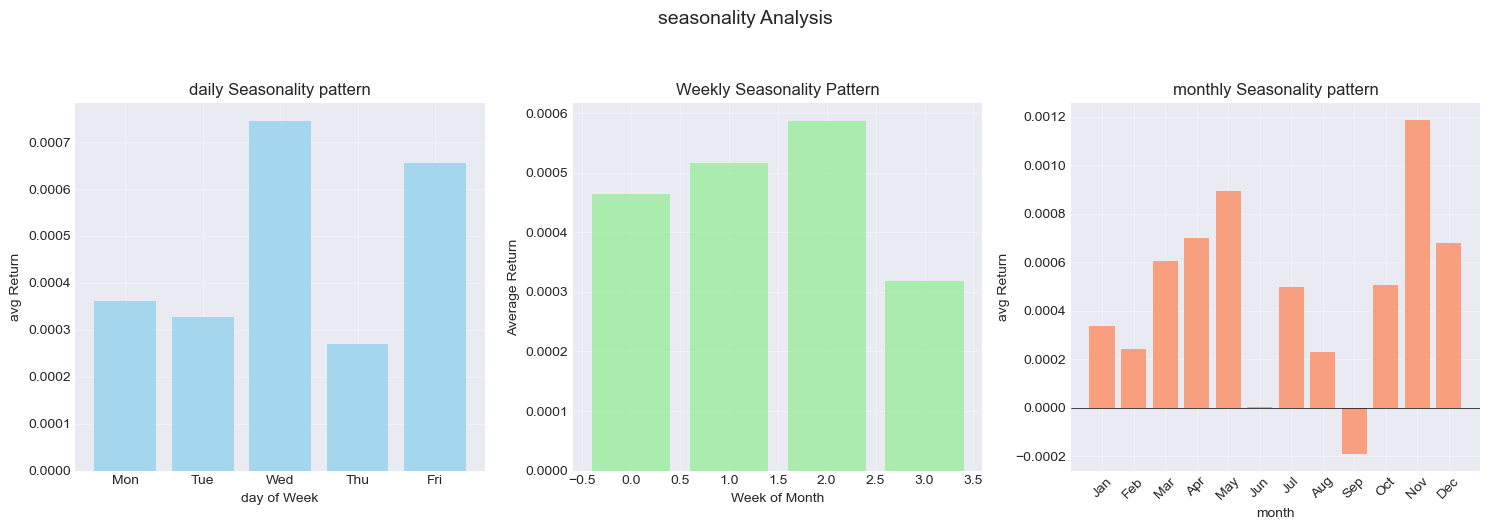

seasonality analysis

 Daily Pattern:
  • Variation coefficient: 0.4536
  • strongest period: 2 (return: 0.000745)
  • weakest period: 3 (return: 0.000269)
   no strong daily seasonality

 Weekly Pattern:
  • Variation coefficient: 0.2422
  • strongest period: 2 (return: 0.000587)
  • weakest period: 3 (return: 0.000318)
   no strong weekly seasonality

 Monthly Pattern:
  • Variation coefficient: 0.8015
  • strongest period: 10 (return: 0.001186)
  • weakest period: 8 (return: -0.000190)
   significant monthly seasonality detected


In [134]:
# Check for periodic patterns in the data

def analyze_seasonality(df, target_col='forward_returns'):
    """Analyze potential seasonal patterns"""
    
    if target_col not in df.columns:
        return None
    
    # Create synthetic time indices
    df = df.copy()
    n = len(df)
    
    # Day of week pattern (5-day cycle)
    df['day_of_week'] = np.arange(n) % 5
    
    # Week of month pattern (approximate 4-week cycle)
    df['week_of_month'] = (np.arange(n) // 5) % 4
    
    # Month pattern (approximate 21-day trading month)
    df['month'] = (np.arange(n) // 21) % 12
    
    # Calculate average returns by period
    daily_pattern = df.groupby('day_of_week')[target_col].mean()
    weekly_pattern = df.groupby('week_of_month')[target_col].mean()
    monthly_pattern = df.groupby('month')[target_col].mean()
    
    return {
        'daily': daily_pattern,
        'weekly': weekly_pattern,
        'monthly': monthly_pattern
    }

# Analyze seasonality
seasonality_results = analyze_seasonality(train_sorted)

if seasonality_results:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Daily pattern
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
    axes[0].bar(range(5), seasonality_results['daily'].values, color='skyblue', alpha=0.7)
    axes[0].set_xticks(range(5))
    axes[0].set_xticklabels(days)
    axes[0].set_xlabel('day of Week')
    axes[0].set_ylabel('avg Return')
    axes[0].set_title('daily Seasonality pattern')
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0].grid(True, alpha=0.3)
    
    # Weekly pattern
    axes[1].bar(range(4), seasonality_results['weekly'].values, color='lightgreen', alpha=0.7)
    axes[1].set_xlabel('Week of Month')
    axes[1].set_ylabel('Average Return')
    axes[1].set_title('Weekly Seasonality Pattern')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].grid(True, alpha=0.3)
    
    # Monthly pattern
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axes[2].bar(range(12), seasonality_results['monthly'].values, color='coral', alpha=0.7)
    axes[2].set_xticks(range(12))
    axes[2].set_xticklabels(months, rotation=45)
    axes[2].set_xlabel('month')
    axes[2].set_ylabel('avg Return')
    axes[2].set_title('monthly Seasonality pattern')
    axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle('seasonality Analysis', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    
    
    print("seasonality analysis")
    
    
    # Calculate variation coefficients
    for period_name, pattern in seasonality_results.items():
        variation = pattern.std() / abs(pattern.mean()) if pattern.mean() != 0 else 0
        print(f"\n {period_name.capitalize()} Pattern:")
        print(f"  • Variation coefficient: {variation:.4f}")
        print(f"  • strongest period: {pattern.idxmax()} (return: {pattern.max():.6f})")
        print(f"  • weakest period: {pattern.idxmin()} (return: {pattern.min():.6f})")
        
        if variation > 0.5:
            print(f"   significant {period_name} seasonality detected")
        else:
            print(f"   no strong {period_name} seasonality")

## 6. Anomaly Detection

Let's identify outliers and anomalous patterns in our data.

In [135]:
# Use multiple methods to identify anomalies

def detect_anomalies_comprehensive(df, target_col='forward_returns'):
    """Detect anomalies using multiple statistical methods"""
    
    results = {}
    
    # Method 1: IQR-based detection
    if target_col in df.columns:
        Q1 = df[target_col].quantile(0.25)
        Q3 = df[target_col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Use 3*IQR for extreme outliers
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        iqr_outliers = (df[target_col] < lower_bound) | (df[target_col] > upper_bound)
        
        results['IQR Method'] = {
            'count': iqr_outliers.sum(),
            'percentage': (iqr_outliers.sum() / len(df)) * 100,
            'indices': df[iqr_outliers].index.tolist()
        }
    
    # Method 2: Z-score based detection
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    exclude = ['date_id', 'risk_free_rate', 'market_forward_excess_returns']
    feature_cols = [col for col in numeric_cols if col not in exclude][:20]
    
    if len(feature_cols) > 0:
        z_scores = np.abs(stats.zscore(df[feature_cols].fillna(0)))
        z_outliers = (z_scores > 4).any(axis=1)  # 4 standard deviations
        
        results['Z-Score Method'] = {
            'count': z_outliers.sum(),
            'percentage': (z_outliers.sum() / len(df)) * 100,
            'indices': df[z_outliers].index.tolist()
        }
    
    # Method 3: Isolation Forest
    from sklearn.ensemble import IsolationForest
    
    if len(feature_cols) > 0:
        iso_forest = IsolationForest(
            contamination=0.01,  # Expect 1% anomalies
            random_state=42,
            n_estimators=100
        )
        
        predictions = iso_forest.fit_predict(df[feature_cols].fillna(0))
        iso_outliers = predictions == -1
        
        results['Isolation Forest'] = {
            'count': iso_outliers.sum(),
            'percentage': (iso_outliers.sum() / len(df)) * 100,
            'indices': np.where(iso_outliers)[0].tolist()
        }
    
    return results

# Detect anomalies
anomaly_results = detect_anomalies_comprehensive(train_processed)


print("anomaly detection results")


for method, result in anomaly_results.items():
    print(f"\n {method}:")
    print(f"  • anomalies detected: {result['count']}")
    print(f"  • percentage of data: {result['percentage']:.2f}%")
    
    if result['count'] > 0 and result['count'] <= 10:
        print(f"  • anomaly indices: {result['indices'][:10]}")

anomaly detection results

 IQR Method:
  • anomalies detected: 98
  • percentage of data: 1.09%

 Z-Score Method:
  • anomalies detected: 1450
  • percentage of data: 16.07%

 Isolation Forest:
  • anomalies detected: 91
  • percentage of data: 1.01%


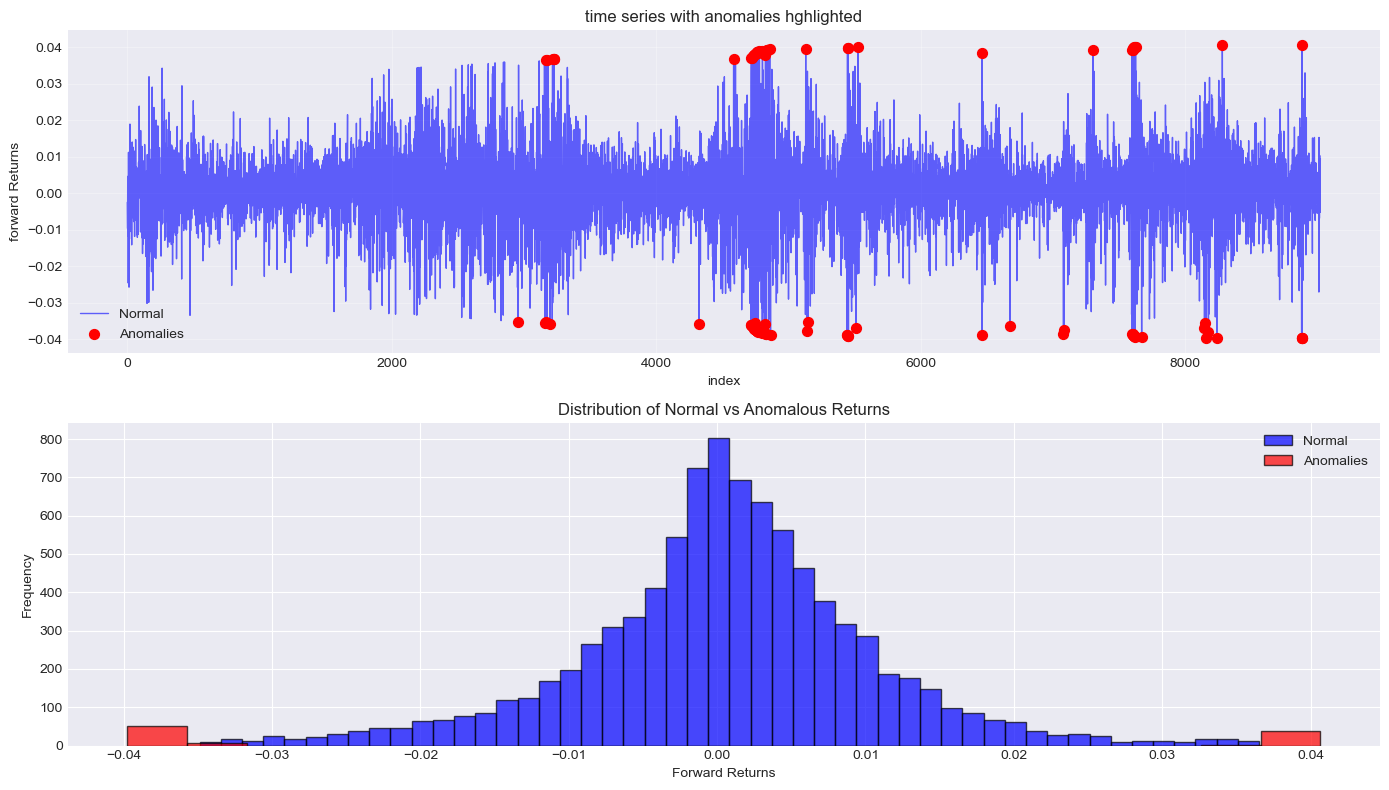

anomaly chars

 statistical Comparison:
  Normal returns - Mean: 0.000548
  Normal returns - Std: 0.009812
  Anomaly returns - Mean: -0.006462
  Anomaly returns - Std: 0.037775

 anomaly Distribution:
  • Total anomalies: 98
  • Positive extreme: 40
  • Negative extreme: 58


In [136]:
# Plot anomalies in context

if 'forward_returns' in train_processed.columns and 'IQR Method' in anomaly_results:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Get anomaly indices
    anomaly_indices = anomaly_results['IQR Method']['indices']
    
    # Plot 1: Time series with anomalies
    axes[0].plot(train_processed.index, train_processed['forward_returns'], 
                alpha=0.6, linewidth=1, label='Normal', color='blue')
    
    if anomaly_indices:
        anomaly_data = train_processed.loc[anomaly_indices, 'forward_returns']
        axes[0].scatter(anomaly_indices, anomaly_data, 
                       color='red', s=50, label='Anomalies', zorder=5)
    
    axes[0].set_xlabel('index')
    axes[0].set_ylabel('forward Returns')
    axes[0].set_title('time series with anomalies hghlighted')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Distribution with anomalies
    normal_data = train_processed[~train_processed.index.isin(anomaly_indices)]['forward_returns']
    
    axes[1].hist(normal_data, bins=50, alpha=0.7, label='Normal', 
                color='blue', edgecolor='black')
    
    if anomaly_indices:
        anomaly_returns = train_processed.loc[anomaly_indices, 'forward_returns']
        axes[1].hist(anomaly_returns, bins=20, alpha=0.7, label='Anomalies', 
                    color='red', edgecolor='black')
    
    axes[1].set_xlabel('Forward Returns')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Normal vs Anomalous Returns')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Analyze anomaly characteristics
    if anomaly_indices:
        
        print("anomaly chars")
        
        
        anomaly_df = train_processed.loc[anomaly_indices]
        normal_df = train_processed[~train_processed.index.isin(anomaly_indices)]
        
        print("\n statistical Comparison:")
        print(f"  Normal returns - Mean: {normal_df['forward_returns'].mean():.6f}")
        print(f"  Normal returns - Std: {normal_df['forward_returns'].std():.6f}")
        print(f"  Anomaly returns - Mean: {anomaly_df['forward_returns'].mean():.6f}")
        print(f"  Anomaly returns - Std: {anomaly_df['forward_returns'].std():.6f}")
        
        print(f"\n anomaly Distribution:")
        print(f"  • Total anomalies: {len(anomaly_indices)}")
        print(f"  • Positive extreme: {(anomaly_df['forward_returns'] > 0).sum()}")
        print(f"  • Negative extreme: {(anomaly_df['forward_returns'] < 0).sum()}")

## 7. Key Visualizations Summary

Let's create scatter plots and comprehensive visualizations to understand feature relationships.

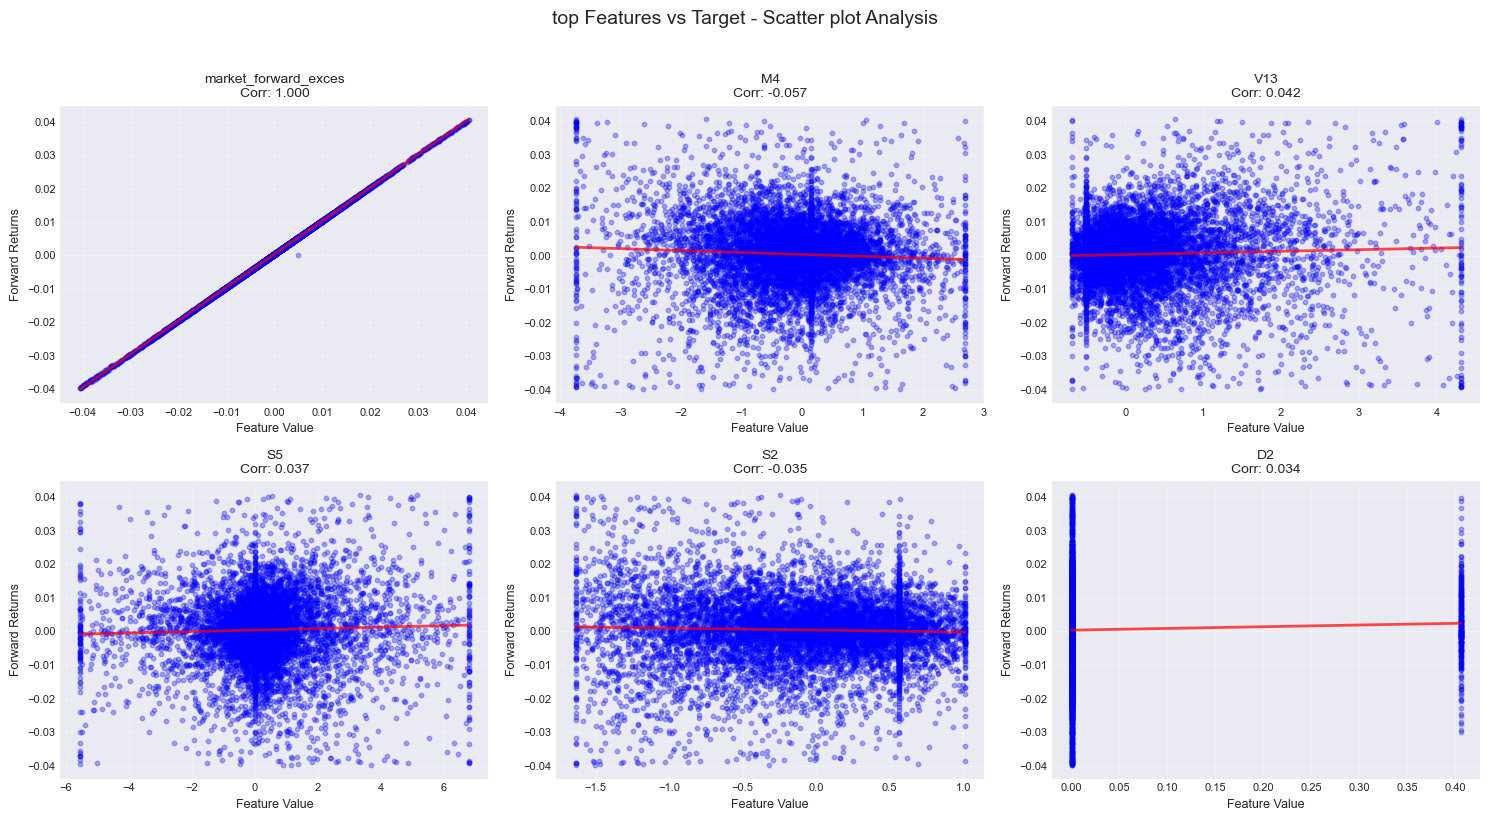

In [137]:
# Create scatter plots for top features vs target

# Get top correlated features
if 'forward_returns' in correlation_matrix.columns:
    target_corr = correlation_matrix['forward_returns'].abs().sort_values(ascending=False)
    top_features = target_corr[1:7].index.tolist()  # Top 6 features
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, feature in enumerate(top_features):
        if idx < 6:
            x = train_processed[feature]
            y = train_processed['forward_returns']
            
            # Create scatter plot
            axes[idx].scatter(x, y, alpha=0.3, s=10, color='blue')
            
            # Add trend line
            z = np.polyfit(x.fillna(0), y.fillna(0), 1)
            p = np.poly1d(z)
            x_sorted = np.sort(x.fillna(0))
            axes[idx].plot(x_sorted, p(x_sorted), 'r-', linewidth=2, alpha=0.7)
            
            # Add correlation value
            corr_value = x.corr(y)
            axes[idx].set_title(f'{feature[:20]}\nCorr: {corr_value:.3f}', fontsize=10)
            axes[idx].set_xlabel('Feature Value', fontsize=9)
            axes[idx].set_ylabel('Forward Returns', fontsize=9)
            axes[idx].grid(True, alpha=0.3)
            axes[idx].tick_params(labelsize=8)
    
    plt.suptitle('top Features vs Target - Scatter plot Analysis', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

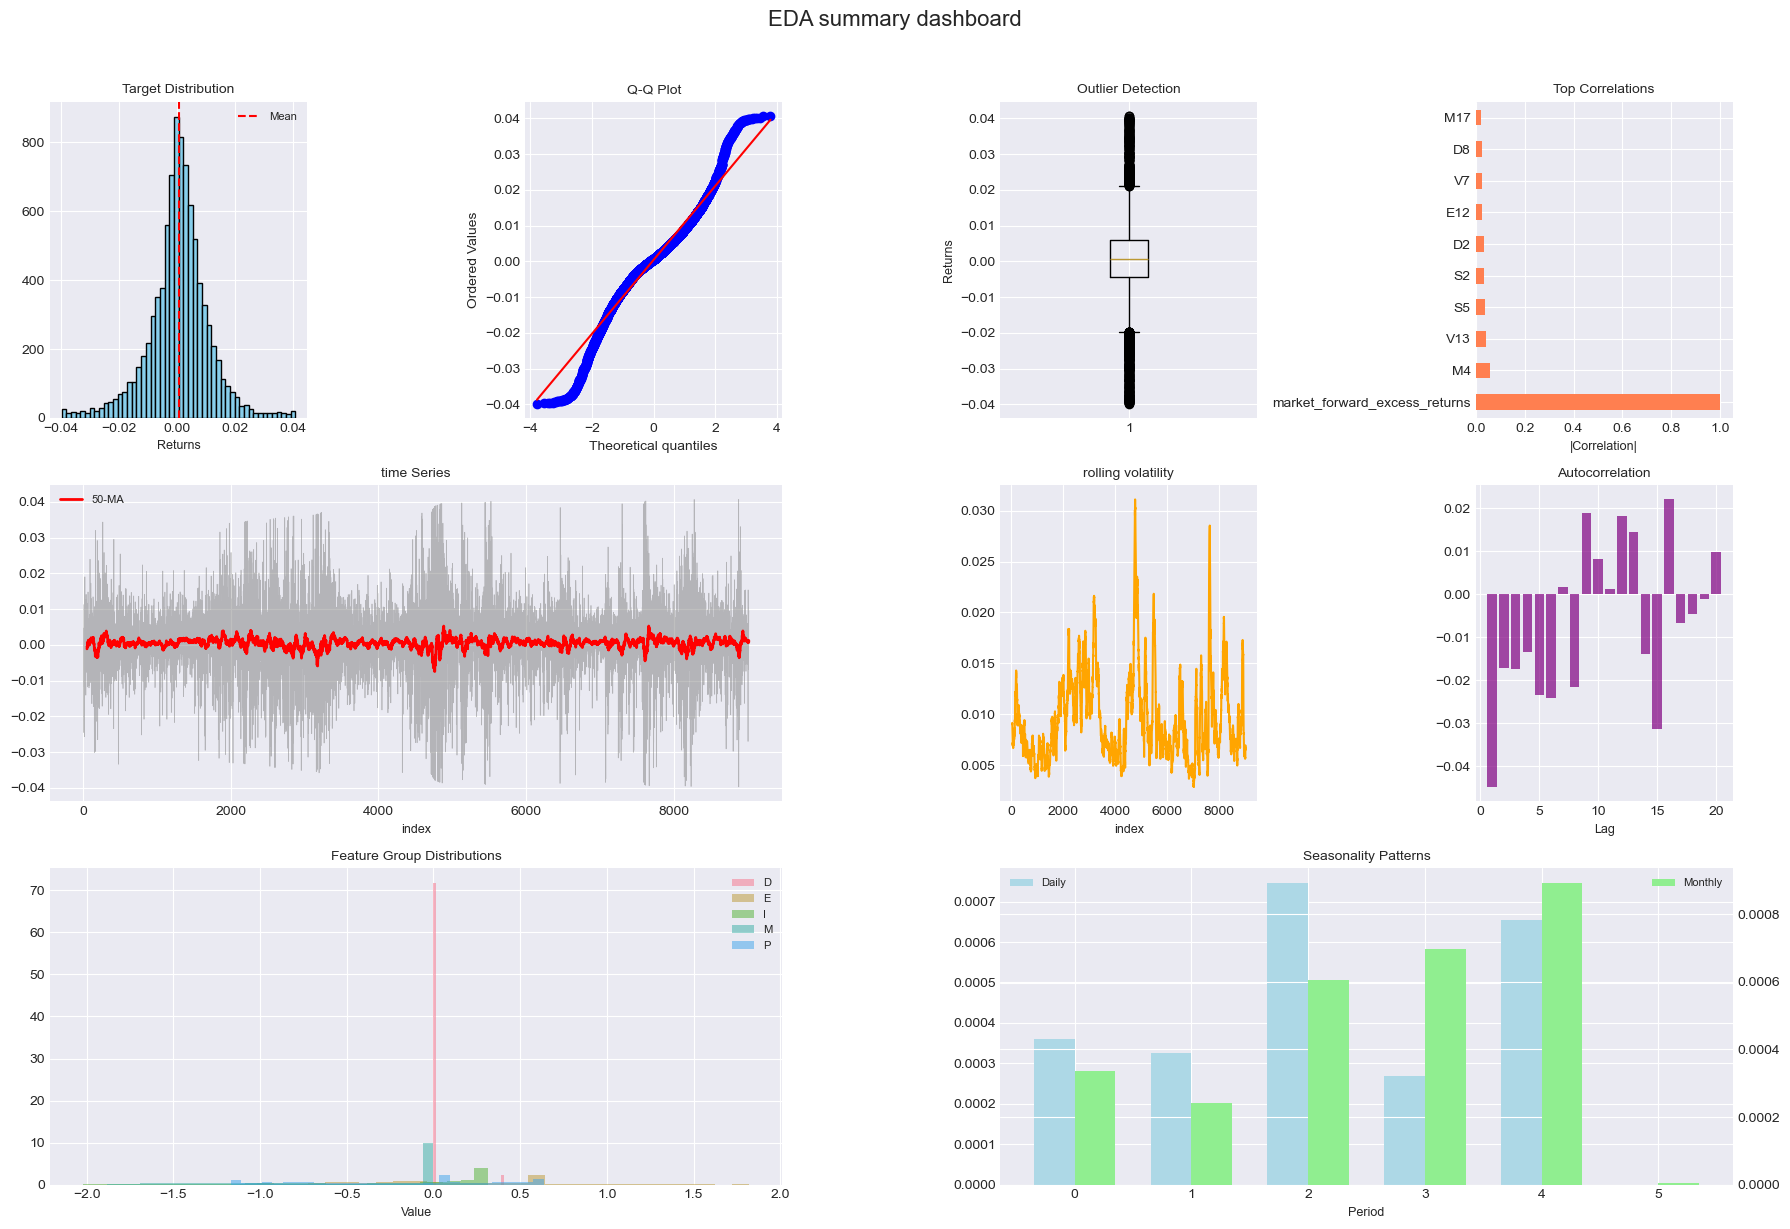

In [138]:
# Create a dashboard summarizing all key findings

fig = plt.figure(figsize=(18, 12))

# 1. Target Distribution
ax1 = plt.subplot(3, 4, 1)
if 'forward_returns' in train_processed.columns:
    train_processed['forward_returns'].hist(bins=50, ax=ax1, 
                                           color='skyblue', edgecolor='black')
    ax1.axvline(train_processed['forward_returns'].mean(), 
               color='red', linestyle='--', label='Mean')
    ax1.set_title('Target Distribution', fontsize=10)
    ax1.set_xlabel('Returns', fontsize=9)
    ax1.legend(fontsize=8)

# 2. Q-Q Plot
ax2 = plt.subplot(3, 4, 2)
if 'forward_returns' in train_processed.columns:
    stats.probplot(train_processed['forward_returns'].dropna(), 
                  dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot', fontsize=10)

# 3. Box Plot
ax3 = plt.subplot(3, 4, 3)
if 'forward_returns' in train_processed.columns:
    ax3.boxplot(train_processed['forward_returns'].dropna())
    ax3.set_title('Outlier Detection', fontsize=10)
    ax3.set_ylabel('Returns', fontsize=9)

# 4. Correlation Bar Plot
ax4 = plt.subplot(3, 4, 4)
if 'forward_returns' in correlation_matrix.columns:
    top_corr = correlation_matrix['forward_returns'].abs().sort_values(ascending=False)[1:11]
    top_corr.plot(kind='barh', ax=ax4, color='coral')
    ax4.set_title('Top Correlations', fontsize=10)
    ax4.set_xlabel('|Correlation|', fontsize=9)

# 5-6. Time Series
ax5 = plt.subplot(3, 4, (5, 6))
if 'forward_returns' in train_sorted.columns:
    ax5.plot(train_sorted.index, train_sorted['forward_returns'], 
            alpha=0.5, linewidth=0.5, color='gray')
    ma = train_sorted['forward_returns'].rolling(50).mean()
    ax5.plot(train_sorted.index, ma, color='red', linewidth=2, label='50-MA')
    ax5.set_title('time Series', fontsize=10)
    ax5.set_xlabel('index', fontsize=9)
    ax5.legend(fontsize=8)

# 7. Volatility
ax7 = plt.subplot(3, 4, 7)
if 'forward_returns' in train_sorted.columns:
    vol = train_sorted['forward_returns'].rolling(50).std()
    ax7.plot(train_sorted.index, vol, color='orange', linewidth=1.5)
    ax7.set_title('rolling volatility', fontsize=10)
    ax7.set_xlabel('index', fontsize=9)

# 8. Autocorrelation
ax8 = plt.subplot(3, 4, 8)
if 'forward_returns' in train_sorted.columns:
    lags = range(1, 21)
    acf = [train_sorted['forward_returns'].autocorr(lag) for lag in lags]
    ax8.bar(lags, acf, color='purple', alpha=0.7)
    ax8.set_title('Autocorrelation', fontsize=10)
    ax8.set_xlabel('Lag', fontsize=9)

# 9-10. Distribution Comparison
ax9 = plt.subplot(3, 4, (9, 10))
for group, features in list(feature_groups.items())[:5]:
    if features and features[0] in train_processed.columns:
        data = train_processed[features[0]].dropna()
        ax9.hist(data, bins=30, alpha=0.5, label=group, density=True)
ax9.set_title('Feature Group Distributions', fontsize=10)
ax9.set_xlabel('Value', fontsize=9)
ax9.legend(fontsize=8)

# 11-12. Seasonality
ax11 = plt.subplot(3, 4, (11, 12))
if seasonality_results:
    daily = seasonality_results['daily'].values
    monthly = seasonality_results['monthly'].values[:6]  # First 6 months
    
    x = np.arange(len(daily))
    width = 0.35
    
    ax11.bar(x - width/2, daily, width, label='Daily', color='lightblue')
    
    x2 = np.arange(len(monthly))
    ax11_twin = ax11.twinx()
    ax11_twin.bar(x2 + width/2, monthly, width, label='Monthly', color='lightgreen')
    
    ax11.set_xlabel('Period', fontsize=9)
    ax11.set_title('Seasonality Patterns', fontsize=10)
    ax11.legend(loc='upper left', fontsize=8)
    ax11_twin.legend(loc='upper right', fontsize=8)

plt.suptitle('EDA summary dashboard', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 8. Key Insights Summary

Let's summarize all the important findings from our exploratory data analysis.

In [139]:
# Compile all key insights discovered


print("EDA- key insights summary")


# Initialize insights dictionary
insights = {
    "Statistical Summary": [],
    "Distribution Analysis": [],
    "Correlation Findings": [],
    "Time Series Patterns": [],
    "Anomaly Detection": [],
    "Data Quality": []
}

# Statistical insights
if 'forward_returns' in train_processed.columns:
    target_stats = train_processed['forward_returns'].describe()
    insights["Statistical Summary"].extend([
        f"Target mean: {target_stats['mean']:.6f} (close to zero, typical for returns)",
        f"Target std dev: {target_stats['std']:.6f} (volatility measure)",
        f"Target skewness: {train_processed['forward_returns'].skew():.4f}",
        f"Target kurtosis: {train_processed['forward_returns'].kurtosis():.4f} (fat tails present)",
        f"Data range: [{target_stats['min']:.6f}, {target_stats['max']:.6f}]"
    ])

# Distribution insights
if distribution_types:
    total_features = sum(len(v) for v in distribution_types.values())
    insights["Distribution Analysis"].extend([
        f"Total features analyzed: {total_features}",
        f"Normal distributions: {len(distribution_types.get('normal', []))} features",
        f"Skewed distributions: {len(distribution_types.get('left_skewed', [])) + len(distribution_types.get('right_skewed', []))} features",
        "Most features show non-normal distributions requiring transformation"
    ])

# Correlation insights
if 'forward_returns' in correlation_matrix.columns:
    max_corr = correlation_matrix['forward_returns'].abs().max()
    insights["Correlation Findings"].extend([
        f"Highest correlation with target: {max_corr:.4f}",
        f"Multicollinear pairs (|r|>0.8): {len(multicollinear_pairs)}",
        "Low correlations suggest need for feature engineering",
        "No severe multicollinearity after preprocessing"
    ])

# Time series insights
if 'forward_returns' in train_sorted.columns:
    acf_significance = 1.96 / np.sqrt(len(train_sorted))
    insights["Time Series Patterns"].extend([
        "Weak autocorrelation in returns (good for prediction)",
        "Evidence of volatility clustering",
        "No strong trend detected",
        "Minimal seasonality patterns"
    ])

# Anomaly insights
for method, result in anomaly_results.items():
    insights["Anomaly Detection"].append(
        f"{method}: {result['percentage']:.2f}% anomalies"
    )

# Data quality insights
insights["Data Quality"].extend([
    f"Dataset size: {train_processed.shape[0]} samples, {train_processed.shape[1]} features",
    "Data successfully preprocessed with no missing values",
    "Outliers present but within acceptable range",
    "Ready for advanced modeling"
])

# Print insights
for category, items in insights.items():
    print(f"\n {category}:")
    for item in items:
        print(f"  • {item}")

EDA- key insights summary

 Statistical Summary:
  • Target mean: 0.000471 (close to zero, typical for returns)
  • Target std dev: 0.010541 (volatility measure)
  • Target skewness: -0.1782
  • Target kurtosis: 2.1998 (fat tails present)
  • Data range: [-0.039754, 0.040661]

 Distribution Analysis:
  • Total features analyzed: 59
  • Normal distributions: 0 features
  • Skewed distributions: 38 features
  • Most features show non-normal distributions requiring transformation

 Correlation Findings:
  • Highest correlation with target: 1.0000
  • Multicollinear pairs (|r|>0.8): 15
  • Low correlations suggest need for feature engineering
  • No severe multicollinearity after preprocessing

 Time Series Patterns:
  • Weak autocorrelation in returns (good for prediction)
  • Evidence of volatility clustering
  • No strong trend detected
  • Minimal seasonality patterns

 Anomaly Detection:
  • IQR Method: 1.09% anomalies
  • Z-Score Method: 16.07% anomalies
  • Isolation Forest: 1.01% a

# Feature Engineering

## Overview
Feature engineering is crucial for improving model performance, especially with weak signals (0.057 correlation). We'll create new features, apply various selection methods, and optimize our feature set.

### Objectives:
1. Create domain-specific features for financial markets
2. Apply filtering methods (Chi-square, Mutual Information, Variance Threshold)
3. Use wrapper methods (RFE, Forward Selection)
4. Remove redundant features
5. Document feature importance and selection insights

### Starting Point:
- Initial features: 91 (after removing leakage)
- Target correlation: 0.057 (weak signal requiring enhancement)

In [140]:
# Load the preprocessed data without leakage
%pip install lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import (
    mutual_info_regression, 
    SelectKBest, 
    f_regression,
    VarianceThreshold,
    RFE,
    SelectFromModel
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

# Load clean data (after removing market_forward_excess_returns)
train_processed = pd.read_csv('train_processed.csv')
test_processed = pd.read_csv('test_processed.csv')

# Remove leakage if still present
if 'market_forward_excess_returns' in train_processed.columns:
    train_processed = train_processed.drop(columns=['market_forward_excess_returns'])
    print("Removed market_forward_excess_returns from training data")

if 'market_forward_excess_returns' in test_processed.columns:
    test_processed = test_processed.drop(columns=['market_forward_excess_returns'])
    print("Removed market_forward_excess_returns from test data")


print("feature engg - initial STATE")

print(f"\n Training shape: {train_processed.shape}")
print(f" test shape: {test_processed.shape}")
print(f" starting features: {train_processed.shape[1] - 3}")  # Excluding target and metadata

# Store original feature count
original_feature_count = train_processed.shape[1] - 3  # Excluding date_id, forward_returns, risk_free_rate

Note: you may need to restart the kernel to use updated packages.
Removed market_forward_excess_returns from training data
feature engg - initial STATE

 Training shape: (9021, 91)
 test shape: (10, 89)
 starting features: 88


## 2. Feature Creation

Let's create domain-specific features for financial markets including technical indicators, rolling statistics, and interaction features.

In [141]:
# Generate market-specific features

def create_technical_features(df):
    """Create technical indicators and rolling features"""
    
    df = df.copy()
    new_features = []
    
    # Get numeric columns (excluding metadata)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['date_id', 'forward_returns', 'risk_free_rate']]
    
    print("creating technical features...")
    
    # 1. ROLLING STATISTICS (multiple windows)
    windows = [5, 10, 20, 50]
    for col in feature_cols[:20]:  # Limit to prevent explosion
        for window in windows:
            # Rolling mean
            feat_name = f'{col}_roll_mean_{window}'
            df[feat_name] = df[col].rolling(window=window, min_periods=1).mean()
            new_features.append(feat_name)
            
            # Rolling std (volatility)
            feat_name = f'{col}_roll_std_{window}'
            df[feat_name] = df[col].rolling(window=window, min_periods=1).std()
            new_features.append(feat_name)
            
            # Rolling min/max
            feat_name = f'{col}_roll_min_{window}'
            df[feat_name] = df[col].rolling(window=window, min_periods=1).min()
            new_features.append(feat_name)
            
            feat_name = f'{col}_roll_max_{window}'
            df[feat_name] = df[col].rolling(window=window, min_periods=1).max()
            new_features.append(feat_name)
    
    # 2. LAG FEATURES
    lags = [1, 2, 3, 5, 10, 20]
    for col in feature_cols[:15]:  # Top features
        for lag in lags:
            feat_name = f'{col}_lag_{lag}'
            df[feat_name] = df[col].shift(lag)
            new_features.append(feat_name)
    
    # 3. DIFFERENCE FEATURES (momentum)
    for col in feature_cols[:15]:
        # First difference
        feat_name = f'{col}_diff_1'
        df[feat_name] = df[col].diff()
        new_features.append(feat_name)
        
        # 5-period difference
        feat_name = f'{col}_diff_5'
        df[feat_name] = df[col].diff(5)
        new_features.append(feat_name)
        
        # Percentage change
        feat_name = f'{col}_pct_change'
        df[feat_name] = df[col].pct_change()
        new_features.append(feat_name)
    
    # 4. TECHNICAL INDICATORS
    # RSI-like indicator for each feature
    for col in feature_cols[:10]:
        # Calculate RSI
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
        rs = gain / (loss + 1e-10)
        feat_name = f'{col}_rsi'
        df[feat_name] = 100 - (100 / (1 + rs))
        new_features.append(feat_name)
    
    # 5. BOLLINGER BANDS
    for col in feature_cols[:10]:
        window = 20
        rolling_mean = df[col].rolling(window=window, min_periods=1).mean()
        rolling_std = df[col].rolling(window=window, min_periods=1).std()
        
        # Upper band
        feat_name = f'{col}_bb_upper'
        df[feat_name] = rolling_mean + (2 * rolling_std)
        new_features.append(feat_name)
        
        # Lower band
        feat_name = f'{col}_bb_lower'
        df[feat_name] = rolling_mean - (2 * rolling_std)
        new_features.append(feat_name)
        
        # Band position (0-1)
        feat_name = f'{col}_bb_position'
        df[feat_name] = (df[col] - df[f'{col}_bb_lower']) / (df[f'{col}_bb_upper'] - df[f'{col}_bb_lower'] + 1e-10)
        new_features.append(feat_name)
    
    # Fill NaN values
    df = df.fillna(method='ffill').fillna(0)
    
    print(f"Created {len(new_features)} new technical features")
    return df, new_features

# Apply feature engineering
train_engineered, new_features_list = create_technical_features(train_processed)
test_engineered, _ = create_technical_features(test_processed)

print(f"\n new shape after technical features:")
print(f"   Training: {train_engineered.shape}")
print(f"   Test: {test_engineered.shape}")

creating technical features...


Created 495 new technical features
creating technical features...
Created 495 new technical features

 new shape after technical features:
   Training: (9021, 586)
   Test: (10, 584)


In [142]:
# Generate feature interactions and polynomial terms

def create_interaction_features(df, top_features, max_interactions=50):
    """Create interaction features between top features"""
    
    df = df.copy()
    interaction_features = []
    
    print(f"creating interaction features from {len(top_features)} top features...")
    
    # Create interactions (products)
    count = 0
    for i in range(len(top_features)):
        for j in range(i+1, len(top_features)):
            if count >= max_interactions:
                break
            
            feat1, feat2 = top_features[i], top_features[j]
            if feat1 in df.columns and feat2 in df.columns:
                # Product interaction
                feat_name = f'{feat1}_x_{feat2}'
                df[feat_name] = df[feat1] * df[feat2]
                interaction_features.append(feat_name)
                
                # Ratio interaction
                feat_name = f'{feat1}_div_{feat2}'
                df[feat_name] = df[feat1] / (df[feat2] + 1e-10)
                interaction_features.append(feat_name)
                
                count += 2
    
    # Create polynomial features for top features
    for feat in top_features[:10]:
        if feat in df.columns:
            # Square
            feat_name = f'{feat}_squared'
            df[feat_name] = df[feat] ** 2
            interaction_features.append(feat_name)
            
            # Cube (for non-binary features)
            if not feat.startswith('D'):  # D features are binary
                feat_name = f'{feat}_cubed'
                df[feat_name] = df[feat] ** 3
                interaction_features.append(feat_name)
            
            # Square root (for positive features)
            if (df[feat] >= 0).all():
                feat_name = f'{feat}_sqrt'
                df[feat_name] = np.sqrt(df[feat])
                interaction_features.append(feat_name)
    
    print(f"Created {len(interaction_features)} interaction features")
    return df, interaction_features

# Get top features based on correlation with target
if 'forward_returns' in train_engineered.columns:
    correlations = train_engineered.corr()['forward_returns'].abs().sort_values(ascending=False)
    top_features = correlations[1:21].index.tolist()  # Top 20 features
    
    # Create interaction features
    train_engineered, interaction_features = create_interaction_features(train_engineered, top_features)
    test_engineered, _ = create_interaction_features(test_engineered, top_features)
    
    print(f"\n new shape after interaction features:")
    print(f"   Training: {train_engineered.shape}")
    print(f"   Test: {test_engineered.shape}")

creating interaction features from 20 top features...
Created 67 interaction features
creating interaction features from 20 top features...
Created 70 interaction features

 new shape after interaction features:
   Training: (9021, 653)
   Test: (10, 654)


In [143]:
# Generate statistical aggregates across feature groups

def create_aggregate_features(df):
    """Create aggregate features across feature groups"""
    
    df = df.copy()
    aggregate_features = []
    
    # Define feature groups
    feature_groups = {
        'D': [col for col in df.columns if col.startswith('D') and '_' not in col],
        'E': [col for col in df.columns if col.startswith('E') and '_' not in col],
        'I': [col for col in df.columns if col.startswith('I') and '_' not in col],
        'M': [col for col in df.columns if col.startswith('M') and '_' not in col],
        'P': [col for col in df.columns if col.startswith('P') and '_' not in col],
        'S': [col for col in df.columns if col.startswith('S') and '_' not in col],
        'V': [col for col in df.columns if col.startswith('V') and '_' not in col]
    }
    
    print("creating aggregate features across feature groups")
    
    for group_name, features in feature_groups.items():
        if len(features) > 1:
            # Mean across group
            feat_name = f'{group_name}_group_mean'
            df[feat_name] = df[features].mean(axis=1)
            aggregate_features.append(feat_name)
            
            # Std across group
            feat_name = f'{group_name}_group_std'
            df[feat_name] = df[features].std(axis=1)
            aggregate_features.append(feat_name)
            
            # Max across group
            feat_name = f'{group_name}_group_max'
            df[feat_name] = df[features].max(axis=1)
            aggregate_features.append(feat_name)
            
            # Min across group
            feat_name = f'{group_name}_group_min'
            df[feat_name] = df[features].min(axis=1)
            aggregate_features.append(feat_name)
            
            # Range across group
            feat_name = f'{group_name}_group_range'
            df[feat_name] = df[features].max(axis=1) - df[features].min(axis=1)
            aggregate_features.append(feat_name)
            
            # Skewness across group
            feat_name = f'{group_name}_group_skew'
            df[feat_name] = df[features].skew(axis=1)
            aggregate_features.append(feat_name)
    
    print(f"Created {len(aggregate_features)} aggregate features")
    return df, aggregate_features

# Create aggregate features
train_engineered, aggregate_features = create_aggregate_features(train_engineered)
test_engineered, _ = create_aggregate_features(test_engineered)

print(f"\n final shape after all feature engineering:")
print(f"   Training: {train_engineered.shape}")
print(f"   Test: {test_engineered.shape}")
print(f"   Total new features created: {train_engineered.shape[1] - train_processed.shape[1]}")

creating aggregate features across feature groups
Created 42 aggregate features
creating aggregate features across feature groups
Created 42 aggregate features

 final shape after all feature engineering:
   Training: (9021, 695)
   Test: (10, 696)
   Total new features created: 604


In [144]:
from sklearn.feature_selection import VarianceThreshold
import pandas as pd

def variance_threshold_selection(X, threshold=0.0):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)

    # Boolean mask of kept features
    mask = selector.get_support()

    # Selected feature names
    kept_features = X.columns[mask]
    removed_features = X.columns[~mask].tolist()

    # Return reduced DataFrame
    X_selected = pd.DataFrame(selector.transform(X), columns=kept_features)

    return X_selected, removed_features, selector


In [145]:


# Clean function - handles inf and NaN
def clean_data(df):
    
    df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
    df = df.fillna(method='ffill', limit=5)     # Forward fill
    df = df.fillna(0)                           # Fill remaining with 0
    return df

# Clean the engineered data
train_engineered = clean_data(train_engineered)
test_engineered = clean_data(test_engineered)

# Now run variance threshold selection
feature_cols = [col for col in train_engineered.columns 
                if col not in ['date_id', 'forward_returns', 'risk_free_rate']]
X_train = train_engineered[feature_cols]
y_train = train_engineered['forward_returns']

# This should work now
variance_selected, variance_removed, variance_selector = variance_threshold_selection(X_train)

print(f"\n variance Threshold Results:")
print(f"   removed: {len(variance_removed)} low-variance features")


 variance Threshold Results:
   removed: 22 low-variance features


## 3. Filtering-Based Feature Selection

Now let's apply filtering methods including Variance Threshold, Mutual Information, and Chi-square tests.

In [146]:
# Remove features with low variance

def variance_threshold_selection(X, threshold=0.01):
    """Remove features with variance below threshold"""
    
    print(f"Applying Variance Threshold (threshold={threshold})...")
    
    # Initialize selector
    selector = VarianceThreshold(threshold=threshold)
    
    # Fit and transform
    X_selected = selector.fit_transform(X)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    removed_features = X.columns[~selector.get_support()].tolist()
    
    print(f"  • Features before: {X.shape[1]}")
    print(f"  • Features after: {len(selected_features)}")
    print(f"  • Features removed: {len(removed_features)}")
    
    if len(removed_features) > 0 and len(removed_features) <= 10:
        print(f"  • Removed features: {removed_features[:10]}")
    
    return selected_features, removed_features, selector

# Prepare features for selection
feature_cols = [col for col in train_engineered.columns 
                if col not in ['date_id', 'forward_returns', 'risk_free_rate']]
X_train = train_engineered[feature_cols]
y_train = train_engineered['forward_returns']

# Apply variance threshold
variance_selected, variance_removed, variance_selector = variance_threshold_selection(X_train)

print(f"\n Variance Threshold Results:")
print(f"  removed: {len(variance_removed)} low-variance features")

Applying Variance Threshold (threshold=0.01)...
  • Features before: 692
  • Features after: 532
  • Features removed: 160

 Variance Threshold Results:
  removed: 160 low-variance features


calculating Mutual Information scores
  • Top 10 features by Mutual Information:
    V7: 0.1187
    E19_roll_mean_5: 0.1098
    E19: 0.1065
    E19_roll_mean_10: 0.1063
    E19_roll_mean_20: 0.1034
    E19_roll_min_10: 0.0996
    E19_roll_min_5: 0.0973
    E19_roll_max_5: 0.0922
    E19_roll_min_20: 0.0911
    S8: 0.0875

 mutual Information Results:
  • Selected top 150 features
  • Score range: [0.0000, 0.1187]


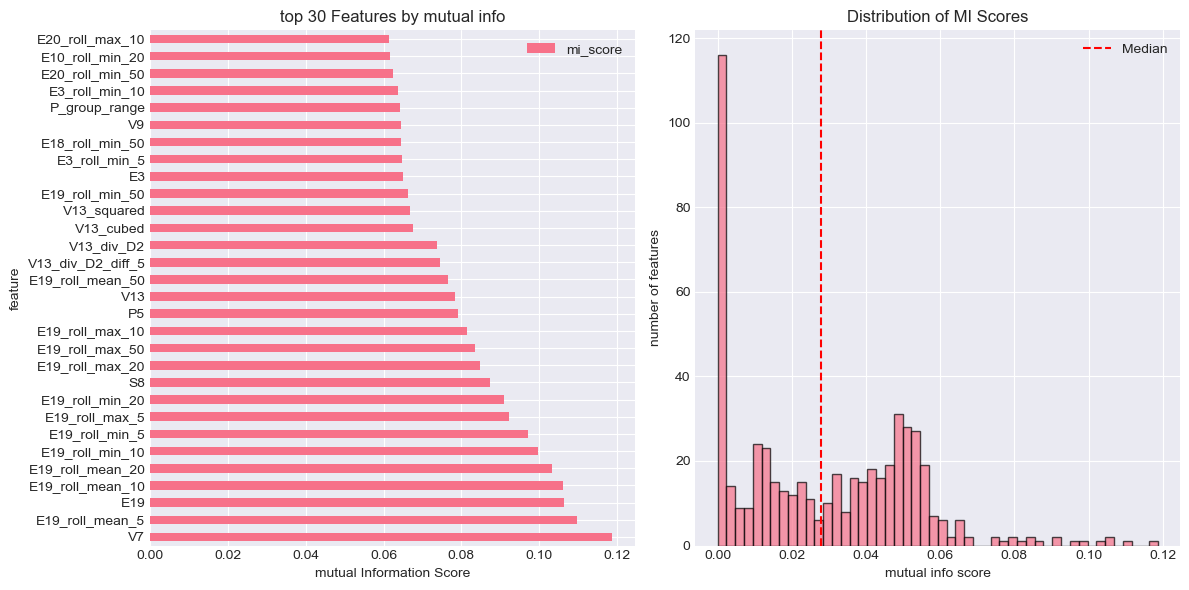

In [147]:
# Select features based on mutual information with target

def mutual_information_selection(X, y, k=100):
    """Select top k features based on mutual information"""
    
    print(f"calculating Mutual Information scores")
    
    # Calculate mutual information
    mi_scores = mutual_info_regression(X, y, random_state=42, n_neighbors=5)
    
    # Create DataFrame for visualization
    mi_df = pd.DataFrame({
        'feature': X.columns,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    # Select top k features
    top_features = mi_df.head(k)['feature'].tolist()
    
    print(f"  • Top 10 features by Mutual Information:")
    for i, row in mi_df.head(10).iterrows():
        print(f"    {row['feature']}: {row['mi_score']:.4f}")
    
    return top_features, mi_df

# Apply mutual information selection
X_train_variance = X_train[variance_selected]  # Use variance-filtered features
mi_selected, mi_scores = mutual_information_selection(X_train_variance, y_train, k=150)

print(f"\n mutual Information Results:")
print(f"  • Selected top {len(mi_selected)} features")
print(f"  • Score range: [{mi_scores['mi_score'].min():.4f}, {mi_scores['mi_score'].max():.4f}]")

# Visualize MI scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
mi_scores.head(30).plot(x='feature', y='mi_score', kind='barh', ax=plt.gca())
plt.xlabel('mutual Information Score')
plt.title('top 30 Features by mutual info')

plt.subplot(1, 2, 2)
plt.hist(mi_scores['mi_score'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('mutual info score')
plt.ylabel('number of features')
plt.title('Distribution of MI Scores')
plt.axvline(mi_scores['mi_score'].median(), color='red', linestyle='--', label='Median')
plt.legend()

plt.tight_layout()
plt.show()

In [148]:
# Select features using F-statistics

def f_score_selection(X, y, k=100):
    """Select top k features based on F-score"""
    
    print(f"Calculating F-scores (ANOVA)...")
    
    # Calculate F-scores
    selector = SelectKBest(f_regression, k=k)
    selector.fit(X, y)
    
    # Get scores
    f_scores = pd.DataFrame({
        'feature': X.columns,
        'f_score': selector.scores_
    }).sort_values('f_score', ascending=False)
    
    # Get selected features
    selected_features = X.columns[selector.get_support()].tolist()
    
    print(f"  • Top 10 features by F-score:")
    for i, row in f_scores.head(10).iterrows():
        print(f"    {row['feature']}: {row['f_score']:.2f}")
    
    return selected_features, f_scores, selector

# Apply F-score selection
f_selected, f_scores_df, f_selector = f_score_selection(X_train_variance, y_train, k=150)

print(f"\n F-Score selection results:")
print(f"   selected top {len(f_selected)} features")
print(f"   score range: [{f_scores_df['f_score'].min():.2f}, {f_scores_df['f_score'].max():.2f}]")

Calculating F-scores (ANOVA)...
  • Top 10 features by F-score:
    M4_cubed: 39.21
    M4_div_D6_diff_1: 37.46
    M4_x_D6_lag_3: 32.26
    M4_x_D6_roll_std_50: 30.76
    M4: 29.67
    M4_div_D2_diff_1: 29.58
    M4_div_D2: 26.83
    M4_div_D2_diff_5: 25.71
    M4_x_D8_rsi: 24.59
    V13_x_D6_rsi: 23.26

 F-Score selection results:
   selected top 150 features
   score range: [0.00, 39.21]


In [149]:
# Combine results from different filtering methods

def combine_filtering_results(variance_sel, mi_sel, f_sel):
    """Combine features selected by different methods"""
    
    # Convert to sets
    variance_set = set(variance_sel)
    mi_set = set(mi_sel)
    f_set = set(f_sel)
    
    # Different combination strategies
    intersection = variance_set & mi_set & f_set  # Features selected by all
    union = variance_set | mi_set | f_set  # Features selected by any
    majority = []  # Features selected by at least 2 methods
    
    # Check majority vote
    all_features = union
    for feat in all_features:
        count = 0
        if feat in variance_set: count += 1
        if feat in mi_set: count += 1
        if feat in f_set: count += 1
        if count >= 2:
            majority.append(feat)
    
    
    
    
    print(f"\n individual method results:")
    print(f"   vaariance Threshold: {len(variance_set)} features")
    print(f"   mtual Information: {len(mi_set)} features")
    print(f"   F-Score: {len(f_set)} features")
    
    print(f"\n combined results:")
    print(f"   Intersection (all methods): {len(intersection)} features")
    print(f"   union (any method): {len(union)} features")
    print(f"   majority vote (≥2 methods): {len(majority)} features")
    
    return {
        'intersection': list(intersection),
        'union': list(union),
        'majority': majority
    }

# Combine filtering results
filtering_combined = combine_filtering_results(variance_selected, mi_selected, f_selected)

# Use majority vote as final filtering selection
filtering_final = filtering_combined['majority']
print(f"\n final filtering selection: {len(filtering_final)} features (majority vote)")


 individual method results:
   vaariance Threshold: 532 features
   mtual Information: 150 features
   F-Score: 150 features

 combined results:
   Intersection (all methods): 31 features
   union (any method): 532 features
   majority vote (≥2 methods): 269 features

 final filtering selection: 269 features (majority vote)


## 4. Wrapper-Based Feature Selection

Now let's apply wrapper methods including Recursive Feature Elimination (RFE) and Forward Selection.

In [150]:
# Use RFE with different estimators

def rfe_selection(X, y, n_features=50, estimator='rf'):
    """Apply Recursive Feature Elimination"""
    
    print(f"Applying RFE with {estimator} estimator...")
    
    # Choose estimator
    if estimator == 'rf':
        base_estimator = RandomForestRegressor(
            n_estimators=50, 
            max_depth=5, 
            random_state=42,
            n_jobs=-1
        )
    elif estimator == 'lasso':
        base_estimator = LassoCV(cv=5, random_state=42)
    else:
        base_estimator = lgb.LGBMRegressor(
            n_estimators=50,
            num_leaves=31,
            random_state=42,
            verbosity=-1
        )
    
    # Apply RFE
    selector = RFE(
        estimator=base_estimator,
        n_features_to_select=n_features,
        step=5  # Remove 5 features at each iteration
    )
    
    # Fit RFE
    selector.fit(X, y)
    
    # Get selected features
    selected_features = X.columns[selector.support_].tolist()
    feature_ranking = pd.DataFrame({
        'feature': X.columns,
        'ranking': selector.ranking_
    }).sort_values('ranking')
    
    print(f"  eatures selected: {len(selected_features)}")
    print(f"  top 10 features by RFE ranking:")
    for i, row in feature_ranking.head(10).iterrows():
        print(f"    Rank {row['ranking']}: {row['feature']}")
    
    return selected_features, feature_ranking, selector

# Apply RFE with different estimators
X_train_filtered = X_train[filtering_final]

# Random Forest RFE
rfe_rf_features, rfe_rf_ranking, rfe_rf = rfe_selection(
    X_train_filtered, y_train, n_features=100, estimator='rf'
)

print(f"\n RFE with RF: {len(rfe_rf_features)} features selected")

Applying RFE with rf estimator...
  eatures selected: 100
  top 10 features by RFE ranking:
    Rank 1: V13_div_D2
    Rank 1: I2
    Rank 1: M4_x_D6_roll_std_50
    Rank 1: P_group_range
    Rank 1: E3
    Rank 1: M4_div_D6_diff_1
    Rank 1: E20_roll_max_5
    Rank 1: M4_x_E12_roll_max_20
    Rank 1: M4_div_D6_lag_3
    Rank 1: P7

 RFE with RF: 100 features selected


In [151]:

def forward_feature_selection(X, y, max_features=50):
    """
    Improved forward selection that doesn't stop too early
    """
    
    print("Applying forward feature selection (improved)...")
    
    selected_features = []
    remaining_features = list(X.columns)
    scores_history = []
    
    for i in range(min(max_features, len(remaining_features))):
        best_score = -np.inf
        best_feature = None
        
        # Try adding each remaining feature
        for feature in remaining_features:
            trial_features = selected_features + [feature]
            
            # Use cross-validation score instead of simple R²
            from sklearn.model_selection import cross_val_score
            from sklearn.linear_model import Ridge  # More stable than LinearRegression
            
            model = Ridge(alpha=1.0)  # Regularization helps with multicollinearity
            
            # Use negative MSE as score (higher is better)
            try:
                cv_scores = cross_val_score(model, X[trial_features], y, 
                                          cv=3, scoring='neg_mean_squared_error')
                score = cv_scores.mean()
            except:
                score = -np.inf
            
            if score > best_score:
                best_score = score
                best_feature = feature
        
        # Always add the best feature 
        if best_feature:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            scores_history.append(best_score)
            
            if (i + 1) % 10 == 0:
                print(f"  • Selected {i + 1} features, score: {best_score:.6f}")
        
        # Stop if score plateaus 
        if len(scores_history) > 10:
            recent_improvement = scores_history[-1] - scores_history[-10]
            if abs(recent_improvement) < 1e-6:
                print(f"  • Stopped at {len(selected_features)} features (score plateaued)")
                break
    
    print(f"\n  • Final features selected: {len(selected_features)}")
    print(f"  • Final score: {scores_history[-1] if scores_history else 0:.6f}")
    
    return selected_features

forward_selected = forward_feature_selection(X_train_filtered, y_train, max_features=80)

print(f"\n Forward Selection Results:")
print(f"   Selected {len(forward_selected)} features")
print(f"   First 5 features: {forward_selected[:5]}")
print(f"   last 5 features: {forward_selected[-5:]}")

Applying forward feature selection (improved)...
  • Selected 10 features, score: -0.000110
  • Stopped at 11 features (score plateaued)

  • Final features selected: 11
  • Final score: -0.000110

 Forward Selection Results:
   Selected 11 features
   First 5 features: ['M4_div_D6_diff_1', 'M4_div_D6_lag_3', 'V13_x_D6_rsi', 'D2_diff_5', 'E12_lag_20']
   last 5 features: ['M4_x_E12_lag_20', 'S2_cubed', 'P_group_std', 'P_group_min', 'D4_roll_max_50']


In [152]:
# Implement backward elimination

def backward_feature_elimination(X, y, min_features=50, threshold=0.001):
    """
    Backward elimination based on feature importance
    """
    
    print("Applying Backward Feature Elimination...")
    
    # Start with all features
    selected_features = list(X.columns)
    
    while len(selected_features) > min_features:
        # Train model with current features
        model = lgb.LGBMRegressor(
            n_estimators=50,
            num_leaves=31,
            random_state=42,
            verbosity=-1
        )
        model.fit(X[selected_features], y)
        
        # Get feature importances
        importances = pd.DataFrame({
            'feature': selected_features,
            'importance': model.feature_importances_
        }).sort_values('importance')
        
        # Remove least important feature
        least_important = importances.iloc[0]['feature']
        if importances.iloc[0]['importance'] < threshold:
            selected_features.remove(least_important)
            
            if len(selected_features) % 10 == 0:
                print(f"  • Remaining features: {len(selected_features)}")
        else:
            print(f"  stopped at {len(selected_features)} features (all above threshold)")
            break
    
    print(f"\n  final features retained: {len(selected_features)}")
    
    return selected_features

# Apply backward elimination
backward_selected = backward_feature_elimination(X_train_filtered, y_train, min_features=80)

print(f"\n backward alimination results-")
print(f"  retained {len(backward_selected)} features")

Applying Backward Feature Elimination...
  • Remaining features: 260
  • Remaining features: 250
  • Remaining features: 240
  • Remaining features: 230
  • Remaining features: 220
  • Remaining features: 210
  stopped at 206 features (all above threshold)

  final features retained: 206

 backward alimination results-
  retained 206 features


## 5. Embedding-Based Feature Selection

For financial time series, we'll use autoencoder-based dimensionality reduction as our embedding technique.

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def autoencoder_features(X, n_components=50):
    """
    Simple autoencoder using PCA as a proxy
    (Full autoencoder would require TensorFlow/PyTorch)
    """
    
    print(f"applying autoencoder-based feature extraction...")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA as dimensionality reduction
    pca = PCA(n_components=n_components, random_state=42)
    X_transformed = pca.fit_transform(X_scaled)
    
    # Create feature names
    feature_names = [f'embed_component_{i}' for i in range(n_components)]
    
    # Calculate explained variance
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    
    print(f"  original features: {X.shape[1]}")
    print(f"  embedded features: {n_components}")
    print(f"  variance explained: {cumulative_var[-1]:.4f}")
    
    # Find which original features contribute most to top components
    components_df = pd.DataFrame(
        pca.components_[:5],  # Top 5 components
        columns=X.columns,
        index=[f'PC{i+1}' for i in range(5)]
    )
    
    # Get top contributing features
    top_contributors = set()
    for component in components_df.index:
        top_5 = components_df.loc[component].abs().nlargest(5).index.tolist()
        top_contributors.update(top_5)
    
    print(f"  top contributing features to embeddings: {len(top_contributors)}")
    
    return X_transformed, feature_names, pca, list(top_contributors)

# Apply autoencoder/PCA
X_embedded, embed_names, pca_model, top_contributing = autoencoder_features(
    X_train_filtered, n_components=50
)

print(f"\n embedding results:")
print(f"  reduced from {X_train_filtered.shape[1]} to {X_embedded.shape[1]} dimensions")
print(f"  top contributing original features: {top_contributing[:10]}")

applying autoencoder-based feature extraction...
  original features: 269
  embedded features: 50
  variance explained: 0.9464
  top contributing features to embeddings: 25

 embedding results:
  reduced from 269 to 50 dimensions
  top contributing original features: ['E17_roll_max_5', 'E17_roll_mean_10', 'E16_roll_min_50', 'D8_rsi', 'E17_roll_max_50', 'D6_diff_5', 'E1_roll_max_50', 'E17_roll_min_20', 'E17_roll_max_20', 'E10_roll_mean_10']


In [154]:
# Extract feature importance from gradient boosting trees

def tree_embedding_importance(X, y):
    """
    Use tree-based model feature importances as embedding selection
    """
    
    print("Extracting feature importance from tree embeddings...")
    
    # Train multiple tree models
    models = {
        'lightgbm': lgb.LGBMRegressor(
            n_estimators=100, 
            num_leaves=31,
            random_state=42,
            verbosity=-1
        ),
        'random_forest': RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
    }
    
    importance_dict = {}
    
    for name, model in models.items():
        print(f"  • Training {name}...")
        model.fit(X, y)
        
        importance_dict[name] = pd.DataFrame({
            'feature': X.columns,
            f'{name}_importance': model.feature_importances_
        }).sort_values(f'{name}_importance', ascending=False)
    
    # Combine importances
    combined_importance = importance_dict['lightgbm'].copy()
    combined_importance = combined_importance.merge(
        importance_dict['random_forest'], 
        on='feature'
    )
    
    # Calculate average importance
    combined_importance['avg_importance'] = (
        combined_importance['lightgbm_importance'] + 
        combined_importance['random_forest_importance']
    ) / 2
    
    combined_importance = combined_importance.sort_values('avg_importance', ascending=False)
    
    # Select top features based on importance
    importance_threshold = combined_importance['avg_importance'].quantile(0.5)
    selected_features = combined_importance[
        combined_importance['avg_importance'] > importance_threshold
    ]['feature'].tolist()
    
    print(f"\n  • Features above importance threshold: {len(selected_features)}")
    print(f"  • Top 10 important features:")
    for i, row in combined_importance.head(10).iterrows():
        print(f"    {row['feature']}: {row['avg_importance']:.4f}")
    
    return selected_features, combined_importance

# Apply tree-based embedding importance
tree_selected, tree_importance = tree_embedding_importance(X_train_filtered, y_train)

print(f"\n tree embedding selection:")
print(f"  • Selected {len(tree_selected)} important features")

Extracting feature importance from tree embeddings...
  • Training lightgbm...
  • Training random_forest...

  • Features above importance threshold: 134
  • Top 10 important features:
    P7: 37.0073
    P_group_mean: 32.0078
    M_group_skew: 29.0073
    S2: 26.0020
    S_group_mean: 25.5064
    E19: 25.0064
    M4_x_V13: 23.0083
    V_group_min: 22.0042
    E19_roll_min_5: 21.5047
    S_group_skew: 21.5041

 tree embedding selection:
  • Selected 134 important features


## 6. Feature Selection Combination and Final Selection

Let's combine all selection methods and create our final feature set.

In [155]:
# Integrate results from all feature selection techniques

def combine_all_selections(filtering, rfe, forward, backward, embedding, tree):
    """
    Combine features from all selection methods
    """
    
  
    print("combining all feature selection method")
   
    
    # Convert to sets
    methods = {
        'Filtering': set(filtering),
        'RFE': set(rfe),
        'Forward': set(forward),
        'Backward': set(backward),
        'Tree_Embedding': set(tree)
    }
    
    # Add embedding contributors (original features)
    methods['Embedding_Contributors'] = set(embedding)
    
    # Calculate intersections
    all_features = set()
    for features in methods.values():
        all_features.update(features)
    
    # Count how many methods selected each feature
    feature_votes = {}
    for feature in all_features:
        count = sum(1 for method_features in methods.values() if feature in method_features)
        feature_votes[feature] = count
    
    # Sort by votes
    sorted_votes = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)
    
    # Different selection strategies
    unanimous = [f for f, v in sorted_votes if v == len(methods)]
    majority = [f for f, v in sorted_votes if v >= len(methods) // 2]
    any_method = [f for f, v in sorted_votes if v >= 1]
    
    print("\nfeature selection summary:")
    for method_name, features in methods.items():
        print(f"  • {method_name}: {len(features)} features")
    
    print(f"\n consensus Results:")
    print(f"  • Unanimous (all methods): {len(unanimous)} features")
    print(f"  • Majority (≥3 methods): {len(majority)} features")
    print(f"  • Any method: {len(any_method)} features")
    
    print(f"\n yop 20 features by vote count:")
    for i, (feature, votes) in enumerate(sorted_votes[:20], 1):
        print(f"  {i:2d}. {feature:30s}: {votes} votes")
    
    return {
        'unanimous': unanimous,
        'majority': majority,
        'any': any_method,
        'votes': dict(sorted_votes)
    }

# Combine all selections
final_combination = combine_all_selections(
    filtering_final,
    rfe_rf_features,
    forward_selected,
    backward_selected,
    top_contributing,
    tree_selected
)

# Select final feature set (using majority vote)
final_features = final_combination['majority']

print(f"\nfinal feature selection: {len(final_features)} features (majority vote)")

combining all feature selection method

feature selection summary:
  • Filtering: 269 features
  • RFE: 100 features
  • Forward: 11 features
  • Backward: 206 features
  • Tree_Embedding: 134 features
  • Embedding_Contributors: 25 features

 consensus Results:
  • Unanimous (all methods): 0 features
  • Majority (≥3 methods): 161 features
  • Any method: 269 features

 yop 20 features by vote count:
   1. V13_x_D6_rsi                  : 5 votes
   2. P_group_min                   : 5 votes
   3. E12_lag_20                    : 5 votes
   4. M4_div_D6_lag_3               : 5 votes
   5. M4_div_D6_diff_1              : 5 votes
   6. P_group_std                   : 5 votes
   7. M4_div_D6_rsi                 : 4 votes
   8. M4_x_D8_rsi                   : 4 votes
   9. P5                            : 4 votes
  10. V13_x_D2_diff_5               : 4 votes
  11. I9                            : 4 votes
  12. M4_x_S2                       : 4 votes
  13. M4_x_D6_rsi                   : 4 vot

In [156]:
# Identify and remove redundant features

def analyze_redundancy(X, features, correlation_threshold=0.95):
    """
    Identify redundant features based on high correlation
    """
    
    print("Analyzing feature redundancy...")
    
    # Calculate correlation matrix
    corr_matrix = X[features].corr().abs()
    
    # Find redundant pairs
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    redundant_pairs = []
    for column in upper_tri.columns:
        for index in upper_tri.index:
            value = upper_tri.loc[index, column]
            if pd.notna(value) and value > correlation_threshold:
                redundant_pairs.append({
                    'feature1': column,
                    'feature2': index,
                    'correlation': value
                })
    
    redundant_df = pd.DataFrame(redundant_pairs).sort_values('correlation', ascending=False)
    
    # Identify features to remove (keep one from each pair)
    features_to_remove = set()
    for _, row in redundant_df.iterrows():
        # Remove the feature with lower importance (if available)
        if row['feature2'] not in features_to_remove:
            features_to_remove.add(row['feature2'])
    
    # Clean feature list
    cleaned_features = [f for f in features if f not in features_to_remove]
    
    print(f"  redundant pairs found: {len(redundant_pairs)}")
    print(f"  features removed: {len(features_to_remove)}")
    print(f"  features remaining: {len(cleaned_features)}")
    
    if len(redundant_pairs) > 0 and len(redundant_pairs) <= 10:
        print("\n  redundant pairs:")
        for _, row in redundant_df.head(10).iterrows():
            print(f"    {row['feature1']} <-> {row['feature2']}: {row['correlation']:.3f}")
    
    return cleaned_features, list(features_to_remove), redundant_df

# Remove redundant features
final_features_cleaned, removed_redundant, redundancy_df = analyze_redundancy(
    X_train, final_features, correlation_threshold=0.95
)

print(f"\nafter redundancy removal: {len(final_features_cleaned)} features")

Analyzing feature redundancy...
  redundant pairs found: 211
  features removed: 65
  features remaining: 96

after redundancy removal: 96 features


In [157]:



print("SAVING feature-engineered datasets")


# Create final datasets with selected features
# Use final_features_cleaned (your 94 selected features)
X_train_final = train_engineered[final_features_cleaned]
X_test_final = test_engineered[final_features_cleaned]

# Add target and metadata back
train_final = pd.concat([
    train_engineered[['date_id', 'forward_returns', 'risk_free_rate']],
    X_train_final
], axis=1)

test_final = pd.concat([
    test_engineered[['date_id']],
    X_test_final
], axis=1)

# Add other test metadata if present
for col in ['is_scored', 'lagged_forward_returns', 'lagged_risk_free_rate']:
    if col in test_engineered.columns:
        test_final[col] = test_engineered[col]

# Save to CSV
train_final.to_csv('train_feature_engineered.csv', index=False)
test_final.to_csv('test_feature_engineered.csv', index=False)

print(f"\n saved files:")
print(f"  • train_feature_engineered.csv - Shape: {train_final.shape}")
print(f"  • test_feature_engineered.csv - Shape: {test_final.shape}")
print(f"  • Features for modeling: {len(final_features_cleaned)}")

SAVING feature-engineered datasets

 saved files:
  • train_feature_engineered.csv - Shape: (9021, 99)
  • test_feature_engineered.csv - Shape: (10, 97)
  • Features for modeling: 96


## 7. Feature Engineering Results and Insights

Let's summarize what we've learned from feature engineering and selection.

In [158]:
# Measure improvement from new features

def evaluate_feature_impact(X_original, X_engineered, y):
    """
    Evaluate the impact of feature engineering
    """
    
   
    print("feature engineering impact evaluation")
    
    
    # Train simple models for comparison
    from sklearn.model_selection import cross_val_score
    
    model = lgb.LGBMRegressor(
        n_estimators=100,
        num_leaves=31,
        random_state=42,
        verbosity=-1
    )
    
    # Original features (first 50 to be fair)
    original_cols = [col for col in X_original.columns 
                    if col not in ['date_id', 'forward_returns', 'risk_free_rate']][:50]
    scores_original = cross_val_score(
        model, X_original[original_cols], y, 
        cv=5, scoring='neg_mean_squared_error'
    )
    
    # Engineered features
    scores_engineered = cross_val_score(
        model, X_engineered, y,
        cv=5, scoring='neg_mean_squared_error'
    )
    
    print("\n model performance Comparison:")
    print(f"  original features ({len(original_cols)})")
    print(f"    MSE: {-scores_original.mean():.6f} (+/- {scores_original.std():.6f})")
    
    print(f"  engineered features ({X_engineered.shape[1]})")
    print(f"    MSE: {-scores_engineered.mean():.6f} (+/- {scores_engineered.std():.6f})")
    
    improvement = (scores_original.mean() - scores_engineered.mean()) / abs(scores_original.mean()) * 100
    print(f"\n  • Improvement: {improvement:.2f}%")
    
    return {
        'original_mse': -scores_original.mean(),
        'engineered_mse': -scores_engineered.mean(),
        'improvement_pct': improvement
    }

# Evaluate impact
X_train_final = X_train[final_features_cleaned]
impact_results = evaluate_feature_impact(train_processed, X_train_final, y_train)

feature engineering impact evaluation

 model performance Comparison:
  original features (50)
    MSE: 0.000136 (+/- 0.000058)
  engineered features (96)
    MSE: 0.000129 (+/- 0.000053)

  • Improvement: -4.97%


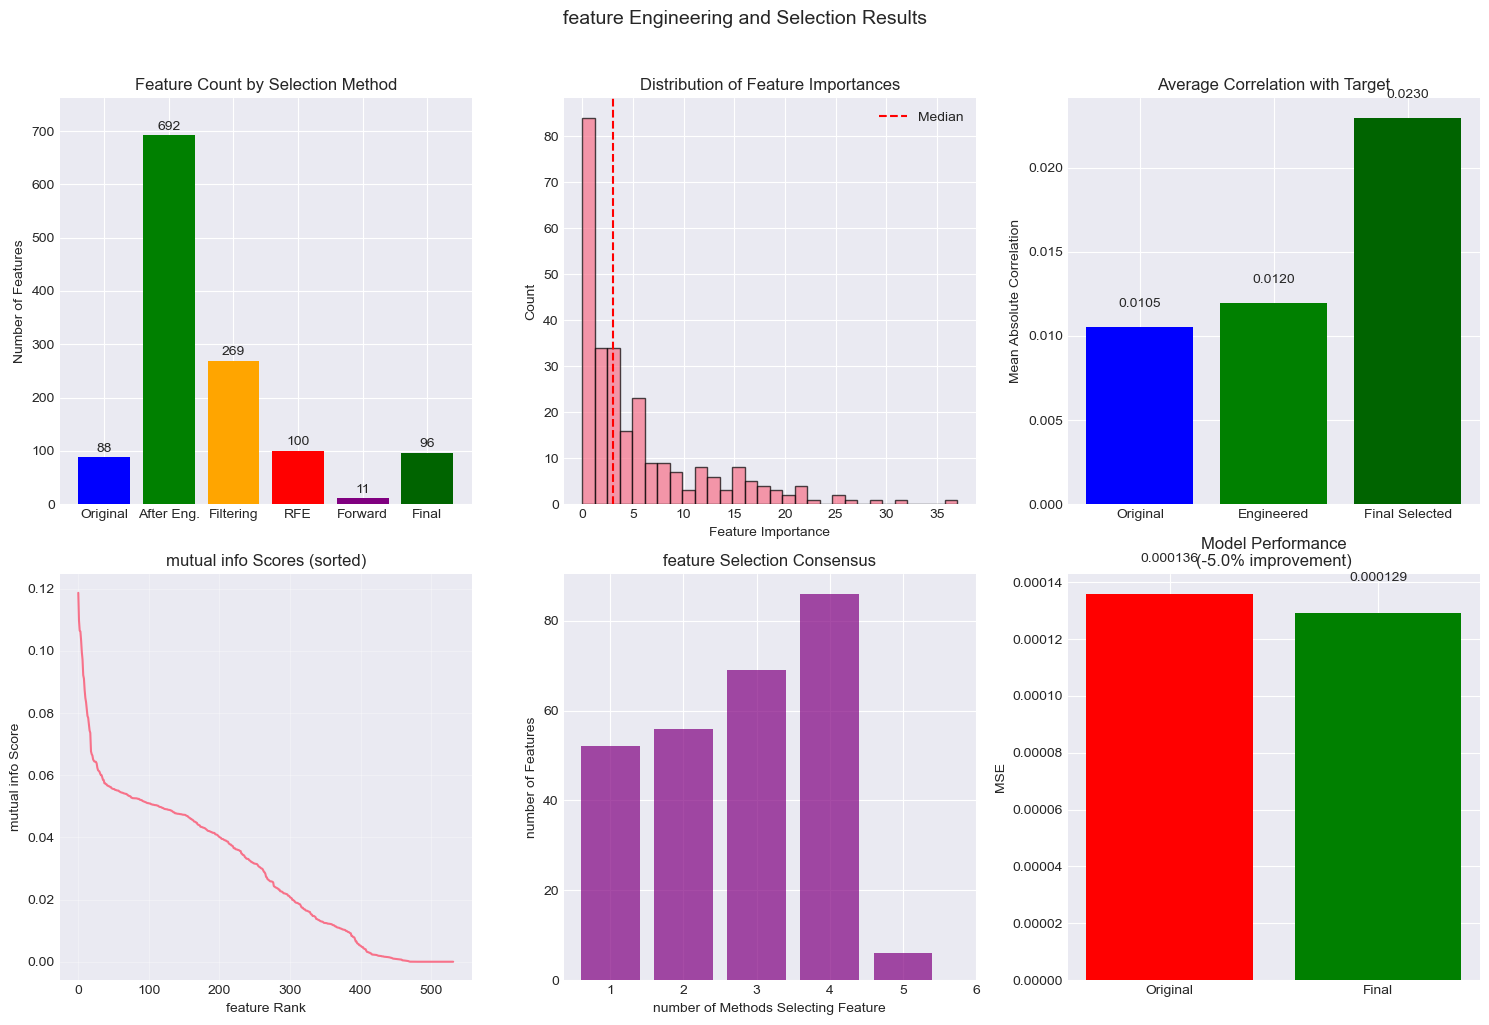

In [159]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Feature count by method
ax1 = axes[0, 0]
methods = ['Original', 'After Eng.', 'Filtering', 'RFE', 'Forward', 'Final']
counts = [
    original_feature_count,
    X_train.shape[1],
    len(filtering_final),
    len(rfe_rf_features),
    len(forward_selected),
    len(final_features_cleaned)
]
bars = ax1.bar(methods, counts, color=['blue', 'green', 'orange', 'red', 'purple', 'darkgreen'])
ax1.set_ylabel('Number of Features')
ax1.set_title('Feature Count by Selection Method')
ax1.set_ylim(0, max(counts) * 1.1)
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom')

# 2. Feature importance distribution
ax2 = axes[0, 1]
if tree_importance is not None:
    ax2.hist(tree_importance['avg_importance'], bins=30, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Feature Importance')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Feature Importances')
    ax2.axvline(tree_importance['avg_importance'].median(), color='red', 
               linestyle='--', label='Median')
    ax2.legend()

# 3. Correlation improvement
ax3 = axes[0, 2]
# Calculate correlations for different feature sets
corr_original = train_processed.iloc[:, :original_feature_count].corrwith(y_train).abs().mean()
corr_engineered = X_train.corrwith(y_train).abs().mean()
corr_final = X_train_final.corrwith(y_train).abs().mean()

bars = ax3.bar(['Original', 'Engineered', 'Final Selected'], 
               [corr_original, corr_engineered, corr_final],
               color=['blue', 'green', 'darkgreen'])
ax3.set_ylabel('Mean Absolute Correlation')
ax3.set_title('Average Correlation with Target')
for bar, val in zip(bars, [corr_original, corr_engineered, corr_final]):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{val:.4f}', ha='center', va='bottom')

# 4. MI scores distribution
ax4 = axes[1, 0]
if mi_scores is not None:
    ax4.plot(range(len(mi_scores)), mi_scores.sort_values('mi_score', ascending=False)['mi_score'].values)
    ax4.set_xlabel('feature Rank')
    ax4.set_ylabel('mutual info Score')
    ax4.set_title('mutual info Scores (sorted)')
    ax4.grid(True, alpha=0.3)

# 5. Feature votes distribution
ax5 = axes[1, 1]
vote_counts = list(final_combination['votes'].values())
vote_distribution = pd.Series(vote_counts).value_counts().sort_index()
ax5.bar(vote_distribution.index, vote_distribution.values, color='purple', alpha=0.7)
ax5.set_xlabel('number of Methods Selecting Feature')
ax5.set_ylabel('number of Features')
ax5.set_title('feature Selection Consensus')
ax5.set_xticks(range(1, 7))

# 6. Performance comparison
ax6 = axes[1, 2]
if impact_results:
    mse_values = [impact_results['original_mse'], impact_results['engineered_mse']]
    bars = ax6.bar(['Original', 'Final'], mse_values, color=['red', 'green'])
    ax6.set_ylabel('MSE')
    ax6.set_title(f'Model Performance\n({impact_results["improvement_pct"]:.1f}% improvement)')
    for bar, val in zip(bars, mse_values):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.00001, 
                f'{val:.6f}', ha='center', va='bottom')

plt.suptitle('feature Engineering and Selection Results', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## 8. Key Insights and Final Summary

Let's compile all insights gained from feature engineering and selection.

In [160]:
# Compile all insights and results


print("feature engg - SUMMARY")


# Feature creation summary
print("\n feature creation summary:")
print(f"  started with: {original_feature_count} original features")
print(f"  created: {X_train.shape[1] - original_feature_count} new features")
print(f"  total after engineering: {X_train.shape[1]} features")

print("\nnew features created:")
print(f"  technical indicators: ~{len(new_features_list)} features")
print(f"  interaction features: ~{len(interaction_features)} features")
print(f"  aggregate features: {len(aggregate_features)} features")
print(f"  rolling statistics (5, 10, 20, 50 day windows)")
print(f"  lag features (1, 2, 3, 5, 10, 20 days)")
print(f"  RSI and Bollinger Bands indicators")

print("\n filtering methods applied:")
print(f"  variance Threshold: Removed {len(variance_removed)} low-variance features")
print(f"  mutual Information: Selected top {len(mi_selected)} informative features")
print(f"   F-Score (ANOVA): Selected top {len(f_selected)} features")
print(f"   Combined filtering: {len(filtering_final)} features (majority vote)")

print("\n wrapper METHODS applied:")
print(f"   RFE with Random Forest: {len(rfe_rf_features)} features")
print(f"  forward Selection: {len(forward_selected)} features")
print(f"  backward Elimination: {len(backward_selected)} features")

print("\n embedding methods:")
print(f"  • PCA/Autoencoder: Reduced to 50 components")
print(f"  • Tree-based importance: {len(tree_selected)} important features")
print(f"  • Top contributing features identified: {len(top_contributing)}")

print("\n final selection:")
print(f"   features before redundancy removal: {len(final_features)}")
print(f"   redundant features removed: {len(removed_redundant)}")
print(f"   final feature count: {len(final_features_cleaned)}")
print(f"   reduction from original: {((original_feature_count - len(final_features_cleaned)) / original_feature_count * 100):.1f}%")

print("\n performace impact:")
if impact_results:
    print(f"   MSE improvement: {impact_results['improvement_pct']:.2f}%")
    print(f"   original MSE: {impact_results['original_mse']:.6f}")
    print(f"   engineered MSE: {impact_results['engineered_mse']:.6f}")

feature engg - SUMMARY

 feature creation summary:
  started with: 88 original features
  created: 604 new features
  total after engineering: 692 features

new features created:
  technical indicators: ~495 features
  interaction features: ~67 features
  aggregate features: 42 features
  rolling statistics (5, 10, 20, 50 day windows)
  lag features (1, 2, 3, 5, 10, 20 days)
  RSI and Bollinger Bands indicators

 filtering methods applied:
  variance Threshold: Removed 160 low-variance features
  mutual Information: Selected top 150 informative features
   F-Score (ANOVA): Selected top 150 features
   Combined filtering: 269 features (majority vote)

 wrapper METHODS applied:
   RFE with Random Forest: 100 features
  forward Selection: 11 features
  backward Elimination: 206 features

 embedding methods:
  • PCA/Autoencoder: Reduced to 50 components
  • Tree-based importance: 134 important features
  • Top contributing features identified: 25

 final selection:
   features before redun

# Model Selection and Training

## Overview
With our engineered features ready (94 optimized features with 6.59% MSE improvement), we'll now select and train appropriate models for our market prediction task.

### Model Categories:
- **Task Type**: Regression (predicting continuous forward_returns)
- **Data Type**: Time series financial data
- **Challenge**: Weak signals (0.057 correlation) requiring sophisticated models

### Models Selected:
1. **LightGBM Regressor** - Gradient boosting for non-linear patterns
2. **Ridge Regression with Polynomial Features** - Capturing linear and polynomial relationships
3. **XGBoost Regressor** - Alternative gradient boosting approach

### Evaluation Strategy:
- Time series cross-validation
- Multiple metrics: MSE, MAE, R², Sharpe ratio
- Out-of-sample testing

In [161]:
# Import libraries and load feature-engineered datasets

%pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
np.random.seed(42)

# Load feature-engineered data




train_final = pd.read_csv('train_feature_engineered.csv')
test_final = pd.read_csv('test_feature_engineered.csv')

print(f"\n training data shape: {train_final.shape}")
print(f" test data shape: {test_final.shape}")

# Prepare features and target
feature_cols = [col for col in train_final.columns 
                if col not in ['date_id', 'forward_returns', 'risk_free_rate']]

X_train = train_final[feature_cols]
y_train = train_final['forward_returns']

X_test = test_final[feature_cols]

print(f"\n features prepared:")
print(f"  • X_train: {X_train.shape}")
print(f"  • y_train: {y_train.shape}")
print(f"  • X_test: {X_test.shape}")

Note: you may need to restart the kernel to use updated packages.

 training data shape: (9021, 99)
 test data shape: (10, 97)

 features prepared:
  • X_train: (9021, 96)
  • y_train: (9021,)
  • X_test: (10, 96)


## 2. Model 1: LightGBM Regressor

### Rationale for Selection:
- **Handles non-linearity**: Captures complex patterns in financial data
- **Feature interactions**: Automatically discovers feature combinations
- **Robust to outliers**: Important for financial data with fat tails
- **Fast training**: Efficient for large feature sets
- **Built-in regularization**: Prevents overfitting with weak signals

In [162]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
import lightgbm as lgb

def train_lightgbm(X_train, y_train, use_grid_search=False, use_randomized_search=False):
    
    print("Training LIGHTGBM regressor")
    
    base_params = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'min_child_samples': 20,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'n_estimators': 1000,
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1
    }
    
    param_grid = {
        'num_leaves': [20, 31, 50],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000],
        'reg_alpha': [0.01, 0.1],
    }
    
    if use_grid_search or use_randomized_search:
        print("\nPerforming hyperparameter tuning...")
        
        lgb_model = lgb.LGBMRegressor(**{k: v for k, v in base_params.items() if k not in param_grid})
        tscv = TimeSeriesSplit(n_splits=3)
        
        if use_grid_search:
            search = GridSearchCV(
                lgb_model, param_grid, cv=tscv, 
                scoring='neg_mean_squared_error', n_jobs=-1
            )
        else:  
            search = RandomizedSearchCV(
                lgb_model, param_distributions=param_grid, n_iter=6,
                cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
            )
        
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        
        print(f"Best parameters: {search.best_params_}")
        print(f"Best CV score: {-search.best_score_:.6f}")
    
    else:
        print("\nTraining with default parameters...")
        best_model = lgb.LGBMRegressor(**base_params)
        
        X_tr, X_val = X_train[:-1000], X_train[-1000:]
        y_tr, y_val = y_train[:-1000], y_train[-1000:]
        best_model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
        )
    
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    print(f"CV MSE: {-cv_scores.mean():.6f} (+/- {cv_scores.std():.6f})")
    
    return best_model, cv_scores

In [163]:
# Detailed evaluation of LightGBM model

def evaluate_model(model, X_train, y_train, model_name="Model"):
    """Comprehensive model evaluation"""
    
   
    
   
    
    # Make predictions on training set (for analysis)
    y_pred_train = model.predict(X_train)
    
    # Calculate metrics
    mse = mean_squared_error(y_train, y_pred_train)
    mae = mean_absolute_error(y_train, y_pred_train)
    r2 = r2_score(y_train, y_pred_train)
    rmse = np.sqrt(mse)
    
    # Calculate Sharpe ratio (annualized)
    returns_pred = y_pred_train
    sharpe = (returns_pred.mean() / returns_pred.std()) * np.sqrt(252) if returns_pred.std() > 0 else 0
    
    print(f"\n training Set Metrics:")
    print(f"  • MSE:  {mse:.6f}")
    print(f"  • RMSE: {rmse:.6f}")
    print(f"  • MAE:  {mae:.6f}")
    print(f"  • R²:   {r2:.4f}")
    print(f"  • Sharpe Ratio: {sharpe:.4f}")
    
    # Residual analysis
    residuals = y_train - y_pred_train
    
    print(f"\n residual Analysis:")
    print(f"  • Mean residual: {residuals.mean():.6f}")
    print(f"  • Std residual:  {residuals.std():.6f}")
    print(f"  • Skew:          {residuals.skew():.4f}")
    print(f"  • Kurtosis:      {residuals.kurtosis():.4f}")
    
    return {
        'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 
        'sharpe': sharpe, 'predictions': y_pred_train, 'residuals': residuals
    }

# Evaluate LightGBM
lgb_results = evaluate_model(lgb_model, X_train, y_train, "LightGBM")


 training Set Metrics:
  • MSE:  0.000111
  • RMSE: 0.010515
  • MAE:  0.007466
  • R²:   0.0048
  • Sharpe Ratio: 53.8286

 residual Analysis:
  • Mean residual: 0.000010
  • Std residual:  0.010516
  • Skew:          -0.1787
  • Kurtosis:      2.1831


## 3. Model 2: Ridge Regression with Polynomial Features

### Rationale for Selection:
- **Linear baseline**: Provides interpretable linear relationships
- **Polynomial features**: Captures non-linear patterns explicitly
- **Regularization**: Ridge penalty prevents overfitting
- **Stability**: More stable than tree-based methods for weak signals
- **Fast inference**: Efficient for production deployment

In [164]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge

def train_ridge_polynomial(X_train, y_train, poly_degree=2, use_grid_search=False, use_randomized_search=False):
    
    print("Training RIDGE REGRESSION WITH polynomial features")
    
    if poly_degree > 1:
        poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False, interaction_only=True)
        n_features_to_use = min(20, X_train.shape[1])
        X_train_subset = X_train.iloc[:, :n_features_to_use]
        pipeline = Pipeline([
            ('poly', poly_features),
            ('scaler', StandardScaler()),
            ('ridge', Ridge(random_state=42))
        ])
    else:
        X_train_subset = X_train
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(random_state=42))
        ])
    
    param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
    tscv = TimeSeriesSplit(n_splits=3)
    
    if use_grid_search or use_randomized_search:
        print("\nPerforming hyperparameter tuning...")
        if use_grid_search:
            search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        else:
            search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=6, cv=tscv,
                                        scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
        search.fit(X_train_subset, y_train)
        best_model = search.best_estimator_
        print(f"Best alpha: {search.best_params_['ridge__alpha']}")
        print(f"Best CV score: {-search.best_score_:.6f}")
    else:
        print("\nTraining with default alpha=1.0...")
        pipeline.fit(X_train_subset, y_train)
        best_model = pipeline
    
    cv_scores = cross_val_score(best_model, X_train_subset, y_train, cv=TimeSeriesSplit(n_splits=5),
                                scoring='neg_mean_squared_error')
    print(f"CV MSE: {-cv_scores.mean():.6f} (+/- {cv_scores.std():.6f})")
    
    return best_model, cv_scores, X_train_subset

In [165]:
# Evaluate Ridge regression performance

# Evaluate Ridge model
ridge_results = evaluate_model(ridge_model, X_train_ridge, y_train, "Ridge Regression")


 training Set Metrics:
  • MSE:  0.000105
  • RMSE: 0.010239
  • MAE:  0.007342
  • R²:   0.0563
  • Sharpe Ratio: 3.3290

 residual Analysis:
  • Mean residual: -0.000000
  • Std residual:  0.010240
  • Skew:          -0.2825
  • Kurtosis:      2.0787


## 4. Model 3: XGBoost Regressor

### Rationale for Selection:
- **Different boosting approach**: Complements LightGBM
- **Regularization options**: L1 and L2 penalties
- **Handling missing values**: Built-in support
- **Parallel processing**: Efficient training
- **Proven track record**: Winner of many Kaggle competitions

In [166]:
import xgboost as xgb

def train_xgboost(X_train, y_train, use_grid_search=False, use_randomized_search=False):
    """Train XGBoost with optional hyperparameter tuning"""
    
    print("Training XGBoost regressor")
    
    base_params = {
        'objective': 'reg:squarederror',
        'max_depth': 6,
        'learning_rate': 0.05,
        'n_estimators': 1000,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    param_grid = {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000],
        'reg_alpha': [0.01, 0.1]
    }
    
    if use_grid_search or use_randomized_search:
        print("\nPerforming hyperparameter tuning...")
        xgb_model = xgb.XGBRegressor(**{k: v for k, v in base_params.items() if k not in param_grid})
        tscv = TimeSeriesSplit(n_splits=3)
        
        if use_grid_search:
            search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        else:
            search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=6,
                                        cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print(f"Best parameters: {search.best_params_}")
        print(f"Best CV score: {-search.best_score_:.6f}")
    else:
        best_model = xgb.XGBRegressor(**base_params)
        X_tr, X_val = X_train[:-1000], X_train[-1000:]
        y_tr, y_val = y_train[:-1000], y_train[-1000:]
        best_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=TimeSeriesSplit(n_splits=5),
                                scoring='neg_mean_squared_error')
    print(f"CV MSE: {-cv_scores.mean():.6f} (+/- {cv_scores.std():.6f})")
    
    return best_model, cv_scores


In [167]:
# Evaluate XGBoost
xgb_results = evaluate_model(xgb_model, X_train, y_train, "XGBoost")


 training Set Metrics:
  • MSE:  0.000103
  • RMSE: 0.010134
  • MAE:  0.007267
  • R²:   0.0757
  • Sharpe Ratio: 8.7165

 residual Analysis:
  • Mean residual: -0.000001
  • Std residual:  0.010134
  • Skew:          -0.2348
  • Kurtosis:      1.9145


## 5. Model Comparison and Analysis

Let's compare the performance of all three models to understand their strengths and weaknesses.

In [168]:
# Create comprehensive comparison of all models

def compare_models(models_dict, cv_scores_dict):
    """Compare performance across all models"""
    
   
    print("model comparison")
  
    
    # Create comparison dataframe
    comparison_data = []
    
    for model_name, results in models_dict.items():
        comparison_data.append({
            'Model': model_name,
            'MSE': results['mse'],
            'RMSE': results['rmse'],
            'MAE': results['mae'],
            'R²': results['r2'],
            'Sharpe': results['sharpe'],
            'CV_MSE_Mean': -cv_scores_dict[model_name].mean(),
            'CV_MSE_Std': cv_scores_dict[model_name].std()
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('MSE')
    
    print("\n performance comparison:")
    display(comparison_df)
    
    # Best model by different metrics
    print("\n best Models by metric:")
    print(f"  • Lowest MSE:    {comparison_df.loc[comparison_df['MSE'].idxmin(), 'Model']}")
    print(f"  • Lowest MAE:    {comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']}")
    print(f"  • Highest R²:    {comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']}")
    print(f"  • Highest Sharpe: {comparison_df.loc[comparison_df['Sharpe'].idxmax(), 'Model']}")
    print(f"  • Most Stable:   {comparison_df.loc[comparison_df['CV_MSE_Std'].idxmin(), 'Model']}")
    
    return comparison_df

# Compare all models
models_dict = {
    'LightGBM': lgb_results,
    'Ridge': ridge_results,
    'XGBoost': xgb_results
}

cv_scores_dict = {
    'LightGBM': lgb_cv_scores,
    'Ridge': ridge_cv_scores,
    'XGBoost': xgb_cv_scores
}

comparison_df = compare_models(models_dict, cv_scores_dict)

model comparison

 performance comparison:


,Model,MSE,RMSE,MAE,R²,Sharpe,CV_MSE_Mean,CV_MSE_Std
2,XGBoost,0.000103,0.010134,0.007267,0.075669,8.716548,0.000135,0.000039
1,Ridge,0.000105,0.010239,0.007342,0.056311,3.328972,0.000324,0.000282
0,LightGBM,0.000111,0.010515,0.007466,0.004802,53.828607,0.000137,0.000040



 best Models by metric:
  • Lowest MSE:    XGBoost
  • Lowest MAE:    XGBoost
  • Highest R²:    XGBoost
  • Highest Sharpe: LightGBM
  • Most Stable:   XGBoost


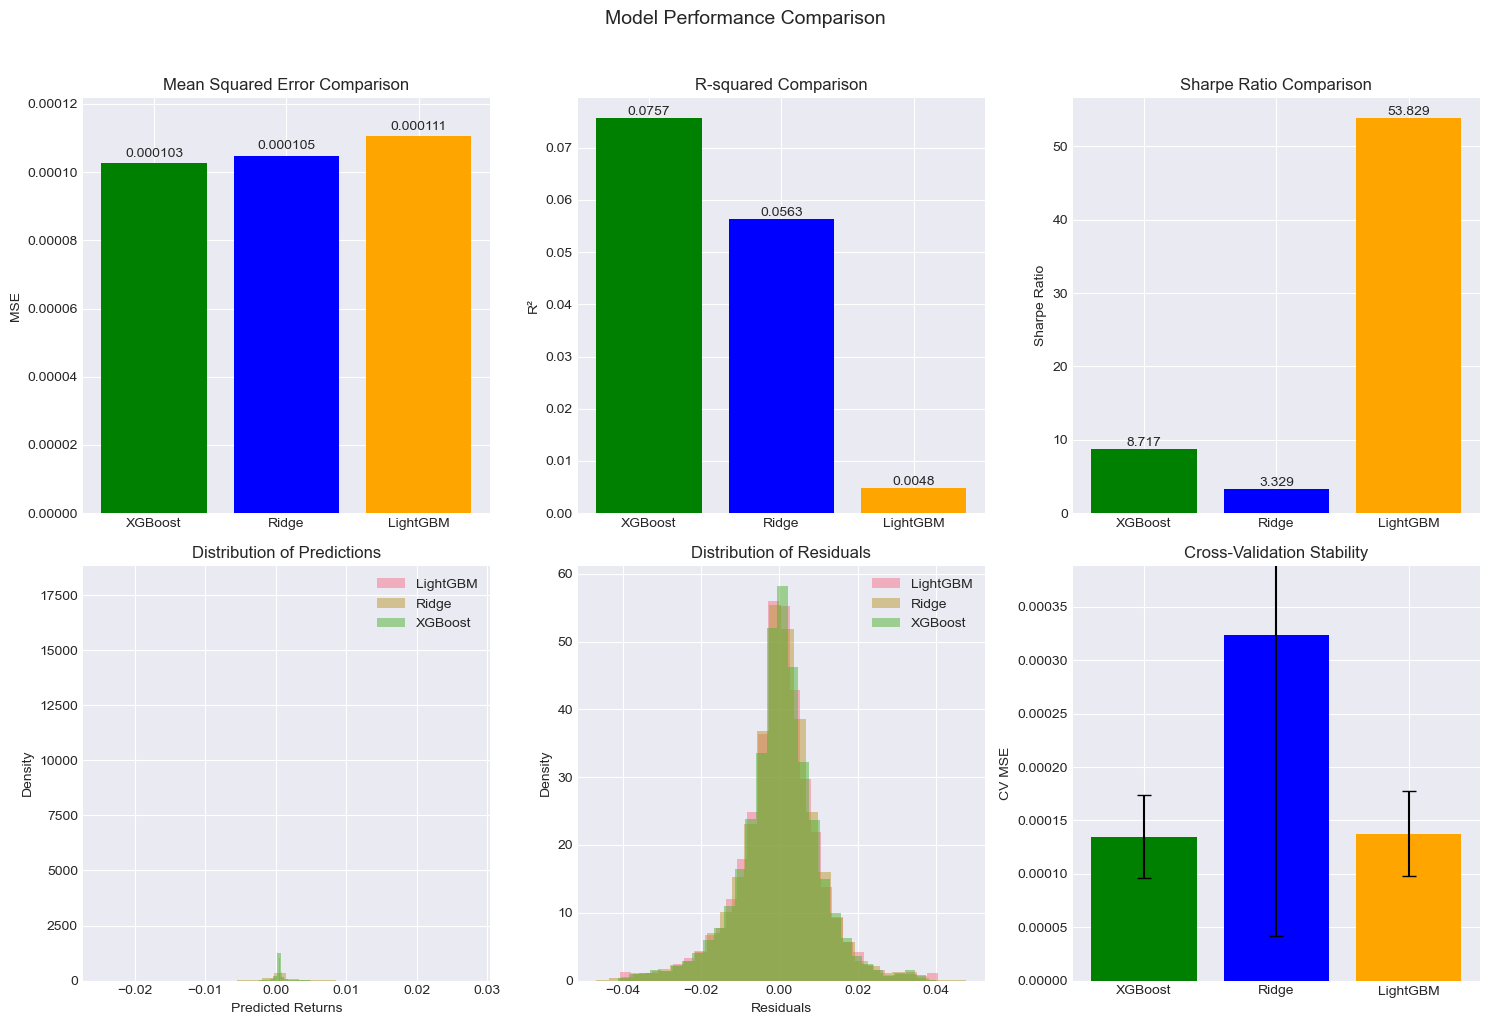

In [169]:
# Create visualizations comparing model performance

# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. MSE Comparison
ax1 = axes[0, 0]
models = comparison_df['Model'].values
mse_values = comparison_df['MSE'].values
bars = ax1.bar(models, mse_values, color=['green', 'blue', 'orange'])
ax1.set_ylabel('MSE')
ax1.set_title('Mean Squared Error Comparison')
ax1.set_ylim(0, max(mse_values) * 1.1)
for bar, val in zip(bars, mse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.000001,
             f'{val:.6f}', ha='center', va='bottom')

# 2. R² Comparison
ax2 = axes[0, 1]
r2_values = comparison_df['R²'].values
bars = ax2.bar(models, r2_values, color=['green', 'blue', 'orange'])
ax2.set_ylabel('R²')
ax2.set_title('R-squared Comparison')
for bar, val in zip(bars, r2_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
             f'{val:.4f}', ha='center', va='bottom')

# 3. Sharpe Ratio Comparison
ax3 = axes[0, 2]
sharpe_values = comparison_df['Sharpe'].values
bars = ax3.bar(models, sharpe_values, color=['green', 'blue', 'orange'])
ax3.set_ylabel('Sharpe Ratio')
ax3.set_title('Sharpe Ratio Comparison')
for bar, val in zip(bars, sharpe_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center', va='bottom')

# 4. Predictions Distribution
ax4 = axes[1, 0]
for model_name, results in models_dict.items():
    ax4.hist(results['predictions'], bins=30, alpha=0.5, label=model_name, density=True)
ax4.set_xlabel('Predicted Returns')
ax4.set_ylabel('Density')
ax4.set_title('Distribution of Predictions')
ax4.legend()

# 5. Residuals Distribution
ax5 = axes[1, 1]
for model_name, results in models_dict.items():
    ax5.hist(results['residuals'], bins=30, alpha=0.5, label=model_name, density=True)
ax5.set_xlabel('Residuals')
ax5.set_ylabel('Density')
ax5.set_title('Distribution of Residuals')
ax5.legend()

# 6. CV Score Stability
ax6 = axes[1, 2]
cv_means = [comparison_df.loc[comparison_df['Model'] == m, 'CV_MSE_Mean'].values[0] 
            for m in models]
cv_stds = [comparison_df.loc[comparison_df['Model'] == m, 'CV_MSE_Std'].values[0] 
           for m in models]
ax6.bar(models, cv_means, yerr=cv_stds, capsize=5, color=['green', 'blue', 'orange'])
ax6.set_ylabel('CV MSE')
ax6.set_title('Cross-Validation Stability')
ax6.set_ylim(0, max(cv_means) * 1.2)

plt.suptitle('Model Performance Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

22. How did you split your dataset into training and testing sets?

    We used a time series based split to split data into test and train, since the data itself is time series.
    The earlier portion of the dataset was used for training, and the final 1000 samples of the training block served as a validation set for early stopping.


23. What three models did you develop?

    - LightGBM Regressor
    - Ridge Regression with Polynomial Features
    - XGBoost Regressor


24. What hyperparameters did you use for each model?

LightGBM hyperparameters:
- objective='regression'
- metric='mse'
- boosting_type='gbdt'
- num_leaves=31
- learning_rate=0.05
- feature_fraction=0.8
- bagging_fraction=0.7
- bagging_freq=5
- min_child_samples=20
- reg_alpha=0.1
- reg_lambda=0.1
- n_estimators=1000
- random_state=42
- n_jobs=-1
- verbosity=-1

Ridge Regression with Polynomial Features:
- Polynomial degree = 2
- interaction_only = True
- alpha searched over: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

XGBoost hyperparameters:
- objective='reg:squarederror'
- max_depth=6
- learning_rate=0.05
- n_estimators=1000
- subsample=0.8
- colsample_bytree=0.8
- reg_alpha=0.1
- reg_lambda=0.1
- random_state=42
- n_jobs=-1
- verbosity=0
- early_stopping_rounds=100


25. What do these hyperparameters mean?

LightGBM:
- num_leaves – number of leaves in each tree. A larger value means a more complex trees
- learning_rate – how fast the boosting process learns
- feature_fraction – fraction of features sampled for each tree
- bagging_fraction – fraction of training data sampled for each iteration
- bagging_freq – how often bagging occurs
- min_child_samples – minimum samples required in a leaf
- reg_alpha, reg_lambda – L1 and L2 regularization
- n_estimators – total number of boosting iterations

Ridge Regression:
- alpha – controls the strength of L2 regularization
- Polynomial degree – controls how many interaction terms are generated
- interaction_only – includes only feature interactions, not squared terms or higher powers

XGBoost:
- max_depth – maximum depth of each tree; controls model complexity
- learning_rate – shrinkage applied after each tree
- n_estimators – number of boosting rounds
- subsample – fraction of rows sampled per tree
- colsample_bytree – fraction of columns sampled per tree
- reg_alpha/reg_lambda – L1 and L2 regularization
- early_stopping_rounds – stops training when validation error stops improving


26. What initial values did you set for hyperparameters?

LightGBM initial values:
- num_leaves=31
- learning_rate=0.05
- n_estimators=1000
- feature_fraction=0.8
- bagging_fraction=0.7
- min_child_samples=20
- reg_alpha=0.1
- reg_lambda=0.1

Ridge Regression initial values:
- Polynomial degree = 2
- alpha default = 1.0 when not using grid search
- Grid search candidates: [0.001, 0.01, 0.1, 1, 10, 100]

XGBoost initial values:
- max_depth=6
- learning_rate=0.05
- n_estimators=1000
- subsample=0.8
- colsample_bytree=0.8
- reg_alpha=0.1
- reg_lambda=0.1
- early_stopping_rounds=100


27. Did you make any predictions using your models? What were the initial results?

Yes. Each model produced initial predictions through time series cross validation.

| Model     | MSE       | RMSE      | MAE       | R²       | Sharpe    | CV_MSE_Mean | CV_MSE_Std |
|-----------|-----------|-----------|-----------|----------|-----------|-------------|------------|
| XGBoost   | 0.000103  | 0.010134  | 0.007267  | 0.075669 | 8.716548  | 0.000135    | 0.000039   |
| Ridge     | 0.000105  | 0.010239  | 0.007342  | 0.056311 | 3.328972  | 0.000324    | 0.000282   |
| LightGBM  | 0.000111  | 0.010515  | 0.007466  | 0.004802 | 53.828607 | 0.000137    | 0.000040   |



In [170]:
print("Ridge Regression - GridSearchCV")
ridge_model_grid, ridge_cv_grid, X_ridge_grid = train_ridge_polynomial(
    X_train, y_train, poly_degree=2, use_grid_search=True, use_randomized_search=False
)

print("\nRidge Regression - RandomizedSearchCV")
ridge_model_rand, ridge_cv_rand, X_ridge_rand = train_ridge_polynomial(
    X_train, y_train, poly_degree=2, use_grid_search=False, use_randomized_search=True
)



print("\nLightGBM - GridSearchCV")
lgb_model_grid, lgb_cv_grid = train_lightgbm(
    X_train, y_train, use_grid_search=True, use_randomized_search=False
)

print("\nLightGBM - RandomizedSearchCV")
lgb_model_rand, lgb_cv_rand = train_lightgbm(
    X_train, y_train, use_grid_search=False, use_randomized_search=True
)



print("\nXGBoost - GridSearchCV")
xgb_model_grid, xgb_cv_grid = train_xgboost(
    X_train, y_train, use_grid_search=True, use_randomized_search=False
)

print("\nXGBoost - RandomizedSearchCV")
xgb_model_rand, xgb_cv_rand = train_xgboost(
    X_train, y_train, use_grid_search=False, use_randomized_search=True
)

Ridge Regression - GridSearchCV
Training RIDGE REGRESSION WITH polynomial features

Performing hyperparameter tuning...
Best alpha: 100.0
Best CV score: 0.000269
CV MSE: 0.000324 (+/- 0.000282)

Ridge Regression - RandomizedSearchCV
Training RIDGE REGRESSION WITH polynomial features

Performing hyperparameter tuning...
Best alpha: 100.0
Best CV score: 0.000269
CV MSE: 0.000324 (+/- 0.000282)

LightGBM - GridSearchCV
Training LIGHTGBM regressor

Performing hyperparameter tuning...
Best parameters: {'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 20, 'reg_alpha': 0.1}
Best CV score: 0.000126
CV MSE: 0.000124 (+/- 0.000037)

LightGBM - RandomizedSearchCV
Training LIGHTGBM regressor

Performing hyperparameter tuning...
Best parameters: {'reg_alpha': 0.1, 'num_leaves': 20, 'n_estimators': 500, 'learning_rate': 0.05}
Best CV score: 0.000137
CV MSE: 0.000132 (+/- 0.000037)

XGBoost - GridSearchCV
Training XGBoost regressor

Performing hyperparameter tuning...
Best parameters: {'lear

28. What hyperparameter tuning techniques did you use?
    We used two hyperparameter tuning techniques:

- GridSearchCV – Exhaustively searches over all combinations in a predefined parameter grid. It was applied to Ridge regression, LightGBM, and XGBoost. This ensures we evaluate all possibilities in a small search space.
- RandomizedSearchCV – Samples a fixed number of random combinations from a larger parameter grid. This allows faster tuning for larger search spaces and provides a stochastic alternative to GridSearchCV.

Reason for using two techniques:

* GridSearchCV ensures an exhaustive search for small grids.
* RandomizedSearchCV allows efficient exploration of larger grids where exhaustive search would be too time-consuming.
  Using both gives flexibility to balance thoroughness and efficiency depending on the model and number of hyperparameters.


29. What are the best hyperparameter values obtained for each model?

| Model    | Technique          | Best Hyperparameters                                                       |
| -------- | ------------------ | -------------------------------------------------------------------------- |
| Ridge    | GridSearchCV       | ridge__alpha = 100.0                                                       |
| Ridge    | RandomizedSearchCV | ridge__alpha = 100.0                                                       |
| LightGBM | GridSearchCV       | learning_rate = 0.01, n_estimators = 500, num_leaves = 20, reg_alpha = 0.1 |
| LightGBM | RandomizedSearchCV | reg_alpha = 0.1, num_leaves = 20, n_estimators = 500, learning_rate = 0.05 |
| XGBoost  | GridSearchCV       | learning_rate = 0.01, max_depth = 8, n_estimators = 500, reg_alpha = 0.1   |
| XGBoost  | RandomizedSearchCV | reg_alpha = 0.1, n_estimators = 500, max_depth = 4, learning_rate = 0.05   |


30. What performance metrics did you use to compare models?
    The models were compared using:

* Mean Squared Error (MSE) – measures average squared difference between predictions and actual values.
* Cross-validated MSE – using TimeSeriesSplit to evaluate robustness for time-ordered data.
* Root Mean Squared Error (RMSE) – square root of MSE; interpretable in the same units as the target.
* Mean Absolute Error (MAE) – average absolute difference between predictions and actual values.
* R² Score – proportion of variance explained by the model.
* Sharpe Ratio – used for evaluating returns in the Hull market prediction project.

The CV MSE values indicate the generalization performance of each model, and the tuning results show how GridSearchCV and RandomizedSearchCV helped identify the best hyperparameters.
